In [4]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
import os
import numpy as np
from scipy.optimize import curve_fit

In [141]:
from PIL import Image
import potential_data
import plots

def plot_relative_variation_potential(data):
    # T = data['T'].iloc[0]
    # sigma = data['sigma'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'beta', height=5, aspect=1.2)
    fg.fig.suptitle(f'relative variation')
    fg.map(plt.errorbar, 'R', 'potential_diff', 'err_diff', marker="o", fmt='', linestyle = ''
    ).add_legend()
    fg.ax.set_xlabel(r"r$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"$\Delta$")
    plt.xlim((0, 2.5))
    plt.ylim((-0.3, 0.3))
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.axhline(y = 0, color = 'k', linestyle = '-')
    # plt.show()

    plots.save_image(f'../images/potential/relative_variation/vitaliy', f'relative_variation', fg)

def relative_variation_potential(paths):
    data = potential_data.read_data_potential(paths)

    data = data[data['potential_su2'] != 0.0]

    data['potential_diff'] = data.apply(lambda x: x['potential_su2'] - x['potential_monopole'] - x['potential_monopoless'], axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_su2'] ** 2 + x['err_monopole'] ** 2 + x['err_monopoless'] ** 2), axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_diff'] ** 2 / x['potential_su2'] ** 2 + x['err_su2'] ** 2 * x['potential_diff'] ** 2 / x['potential_su2'] ** 4), axis=1)
    data['potential_diff'] = data.apply(lambda x: x['potential_diff'] / x['potential_su2'], axis=1)

    data['R'] = data.apply(lambda x: x['R'] * x['sigma'], axis = 1)

    plot_relative_variation_potential(data)


def plot_potential_decomposition(data, y_lims, ls_arr, marker_arr, fillstyle_arr, colors, image_path, image_name, title):
    fg = seaborn.FacetGrid(data=data, hue = 'matrix_type', height=5, aspect=1.4, legend_out=False, 
    hue_kws={"ls" : ls_arr, "marker" : marker_arr, 
    "fillstyle" : fillstyle_arr,"color" : colors})
    map = fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', ms = 8, capsize = 8, lw = 0.5).add_legend(title='')
    # fg.figure.suptitle(title)
    fg.ax.set_title(title, loc='center')
    fg.ax.set_xlabel(r"R$/r_{0}$")
    fg.ax.set_ylabel(r"$r_{0}V(R)$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    fg.ax.set_ylim(y_lims[0], y_lims[1])

    return fg

def join_back(data, matrix_types):
    data1 = []
    for matrix_type in matrix_types:
        data1.append(data[['r/a', f'aV(r)_{matrix_type}', f'err_{matrix_type}']])
        data1[-1] = data1[-1].rename(columns={f'aV(r)_{matrix_type}': 'aV(r)', f'err_{matrix_type}': 'err'})
        data1[-1]['matrix_type'] = matrix_type

    return pd.concat(data1)

def find_sum(data, term1, term2, sum):
    data[f'err_' + sum] = data.apply(lambda x: math.sqrt(x[f'err_' + term1] ** 2 + x[f'err_' + term2] ** 2), axis = 1)
    data[f'aV(r)_' + sum] = data.apply(lambda x: x[f'aV(r)_' + term1] + x[f'aV(r)_' + term2], axis = 1)

    return data

def func_exponent(x, a, b, c):
    return a + b * np.exp(-x * c)

def func_quark_potential(x, c, alpha, sigma):
    return c + alpha * np.power(x, -1) + sigma * x

def func_coloumb(x, c, alpha):
    return c + alpha * np.power(x, -1)

def func_linear(x, c, sigma):
    return c + sigma * x

def fit_potential(data, fit_function, fit_range, fit_name):
    r = data['r/a'].iloc[0]
    data = data[(data['T'] >= fit_range[0]) & (data['T'] <= fit_range[1])]
    y = data['aV(r)_' + fit_name]
    y_err = data['err_' + fit_name]
    x = data['T']
    try:
        popt, pcov = curve_fit(fit_function, x, y, sigma=y_err)
        val = popt[0]
        err = np.sqrt(np.diag(pcov)[0])
    except:
        print('potential fit did not converge at r =', r)
        val = data.loc[data['T'] == 5, 'aV(r)_' + fit_name].iloc[0]
        err = data.loc[data['T'] == 5, 'err_' + fit_name].iloc[0]
    return pd.DataFrame([[val, err]], columns = ['aV(r)_' + fit_name, 'err_' + fit_name])
    

def get_potential_fit(data, fit_func, fit_range, fit_name):
    return data.groupby(['r/a']).apply(fit_potential, fit_func, fit_range, fit_name).reset_index('r/a').reset_index()

def fit_string(data, fit_range, fit_name):
    data = data[(data['r/a'] >= fit_range[0]) & (data['r/a'] <= fit_range[1])]
    y = data['aV(r)_' + fit_name]
    y_err = data['err_' + fit_name]
    x = data['r/a'].to_numpy(dtype=np.float64)
    popt, pcov = curve_fit(func_quark_potential, x, y, sigma = y_err)
    return popt

def fit_consts(data, coloumb_name, string_name, alpha, sigma):
    y_coloumb = data['aV(r)_' + coloumb_name]
    y_string = data['aV(r)_' + string_name]
    x = data['r/a'].to_numpy(dtype=np.float64)
    c_coloumb, err_coloumb = curve_fit(lambda x, c: c + alpha * np.power(x, -1), x, y_coloumb)
    c_string, err_string = curve_fit(lambda x, c: c + sigma * x, x, y_string)
    return c_coloumb, c_string

def make_fit_original(data, orig_pot_name, coloumb_name, string_name, fit_range):
    c, alpha, sigma = fit_string(data, fit_range, orig_pot_name)
    c_coloumb, c_string = fit_consts(data, coloumb_name, string_name, alpha, sigma)
    x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
    y_coloumb = func_coloumb(x_fit, c_coloumb, alpha)
    y_string = func_linear(x_fit, c_string, sigma)
    y_original = func_quark_potential(x_fit, c, alpha, sigma)
    return pd.DataFrame(np.array([x_fit, y_coloumb, y_string, y_original]).T, 
                            columns = ['r/a', 'aV(r)_' + coloumb_name, 
                                        'aV(r)_' + string_name, 'aV(r)_' + orig_pot_name])

def make_fit_separate(data, terms, fit_range, r0):
    x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
    data = data[(data['r/a'] >= fit_range[0]) & (data['r/a'] <= fit_range[1])].reset_index()
    data_fits = []
    columns = []
    x = data['r/a'].to_numpy(dtype=np.float64)
    data_fits.append(x_fit)
    columns.append('r/a')
    for term in terms:
        y = data['aV(r)_' + term]
        y_err = data['err_' + term]
        popt, pcov = curve_fit(func_quark_potential, x, y, sigma = y_err)
        perr = np.sqrt(np.diag(pcov))
        chi_sq = chi_square(x, y, popt[0], popt[1], popt[2])
        # print('aV(r)_' + term, popt[0] / r0, perr[0] / r0,
        #                         popt[1], perr[1], popt[2] / r0**2, 
        #                         perr[2] / r0**2, 'chi_sq =', chi_sq)
        data_fits.append(func_quark_potential(x_fit, *popt))
        columns.append(f'aV(r)_' + term)
    return pd.DataFrame(np.array(data_fits).T, columns = columns)

def get_terms(paths):
    terms = []
    for key, value in paths.items():
        terms.append(value['name'])
    if 'monopole' in paths and 'monopoless' in paths:
        monopole_name = paths['monopole']['name']
        monopoless_name = paths['monopoless']['name']
        terms.append(f'{monopole_name}+{monopoless_name}')
    if 'abelian' in paths and 'offdiagonal' in paths:
        abelian_name = paths['abelian']['name']
        offdiagonal_name = paths['offdiagonal']['name']
        terms.append(f'{abelian_name}+{offdiagonal_name}')
    return terms

def chi_square(x, y, c, alpha, sigma):
    chi_sq = 0
    for i in range(len(x)):
        expected = func_quark_potential(x[i], c, alpha, sigma)
        chi_sq += (expected - y[i])**2 / expected
    return chi_sq

# find a/r_0 for 5.7 <= beta <= 6.92
def get_r0(beta):
    return math.exp(-1.6804 - 1.7331 * (beta - 6) + 0.7849 * (beta - 6)**2 - 0.4428 * (beta - 6)**3)

def potential_decomposition(paths, image_path, image_name, beta, y_lims, fit_original, r0, fit_range, remove_from_plot, black_colors):
    data = potential_data.read_data_potential1(paths)
    data1 = []
    for type, path in paths.items():
        if 'T' in path:
            data1.append(data[data['T'] == path['T']].reset_index()[['r/a', 'aV(r)_' + path['name'], 'err_' + path['name']]])
        else:
            data1.append(get_potential_fit(data, func_exponent, (2, 8), path['name']))

    data = pd.concat(data1, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    terms = get_terms(paths)
    terms_fit = list(terms)

    data_fits = [] 
    if fit_original:
        if 'original' in paths and 'monopole' in paths and 'monopoless' in paths:
            data_fits.append(make_fit_original(data, paths['original']['name'], paths['monopoless']['name'], paths['monopole']['name'], fit_range))
            for term in [paths['original']['name'], paths['monopoless']['name'], paths['monopole']['name']]:
                try:
                    terms_fit.remove(term)
                except:
                    pass
        if 'original' in paths and 'abelian' in paths and 'offdiagonal' in paths:
            data_fits.append(make_fit_original(data, paths['original']['name'], paths['offdiagonal']['name'], paths['abelian']['name'], fit_range))
            for term in [paths['original']['name'], paths['offdiagonal']['name'], paths['abelian']['name']]:
                try:
                    terms_fit.remove(term)
                except:
                    pass

    if 'monopole' in paths and 'monopoless' in paths:
        monopole_name = paths['monopole']['name']
        monopoless_name = paths['monopoless']['name']
        sum_name = f'{monopole_name}+{monopoless_name}'
        data = find_sum(data, paths['monopole']['name'], paths['monopoless']['name'], sum_name)

    if 'abelian' in paths and 'offdiagonal' in paths:
        abelian_name = paths['abelian']['name']
        offdiagonal_name = paths['offdiagonal']['name']
        sum_name = f'{abelian_name}+{offdiagonal_name}'
        data = find_sum(data, paths['abelian']['name'], paths['offdiagonal']['name'], sum_name)

    data_fits.append(make_fit_separate(data, terms_fit, fit_range, r0))

    data_fits = pd.concat(data_fits, axis = 1)
    data_fits = data_fits.loc[:,~data_fits.columns.duplicated()]

    data['r/a'] = data['r/a'] * r0
    for term in terms:
        data[f'aV(r)_' + term] = data[f'aV(r)_' + term] / r0
        data[f'err_' + term] = data[f'err_' + term] / r0

    data_fits['r/a'] = data_fits['r/a'] * r0
    for term in terms:
        data_fits['aV(r)_' + term] = data_fits['aV(r)_' + term] / r0

    for term in remove_from_plot:
        terms.remove(paths[term]['name'])
        data = data.drop(f'aV(r)_' + paths[term]['name'], axis=1)
        data = data.drop(f'err_' + paths[term]['name'], axis=1)

    data = join_back(data, terms)

    ls_arr = ['', '', '', '', '', '', '']
    marker_arr = ['o', 'v', 'o', '^', 's', 's', 'D']
    fillstyle_arr = ['full', 'full', 'none', 'full', 'full', 'none', 'none']
    if black_colors:
        colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black']
    else:
        colors = ['mediumblue', 'orange', 'g', 'r', 'rebeccapurple', 'saddlebrown', 'olive']
    fg = plot_potential_decomposition(data, y_lims, ls_arr, marker_arr, fillstyle_arr, colors, image_path, image_name)

    for i in range(len(terms)):
        seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + terms[i], color=colors[i])

    plt.show()
    plots.save_image(image_path, image_name, fg)

def plot_together(data):
    fg = seaborn.FacetGrid(data=data, hue = 'type', height=5, aspect=1.4, legend_out=False)
    fg.fig.suptitle(f'potentials together')
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5, ls = '-'
    ).add_legend()
    # plt.legend(loc='upper left')
    fg.ax.set_xlabel(r"R$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"V(r)/$\sigma$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.grid(dash_capstyle = 'round')

    plt.show()

def potentials_together(paths, sigma, r_max):
    data = potential_data.read_data_potentials_together(paths, sigma)

    data = data[data['r/a'] <= r_max]

    plot_together(data)

def potential_decomposition_vitaly(path, image_path, image_name, coefs, terms, y_lims, beta):
    data = potential_data.read_vitaly_potential(path)

    terms.append(f'{terms[1]}+{terms[2]}')
    data = find_sum(data, terms[1], terms[2], terms[3])

    r0 = get_r0(beta)
    data['r/a'] = data['r/a'] * r0
    for term in terms:
        data[f'aV(r)_' + term] = data[f'aV(r)_' + term] / r0
        data[f'err_' + term] = data[f'err_' + term] / r0

    data = join_back(data, [terms[0], terms[1], terms[2], terms[3]])

    ls_arr = ['', '', '', '']
    marker_arr = ['o', 'v', 'o', '^']
    fillstyle_arr = ['full', 'full', 'none', 'full']
    colors = ['mediumblue', 'orange', 'g', 'r']
    fg = plot_potential_decomposition(data,y_lims, ls_arr, marker_arr, fillstyle_arr, colors, image_path, image_name)

    data_fits = []
    columns = []
    x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
    data_fits.append(x_fit)
    columns.append('r/a')
    for term in terms:
        data_fits.append(func_quark_potential(x_fit, *coefs[term]))
        columns.append(f'aV(r)_' + term)
    data_fits = pd.DataFrame(np.array(data_fits).T, columns = columns)

    colors = ['mediumblue', 'orange', 'g', 'r']
    for i in range(len(terms)):
        seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + terms[i], color=colors[i])

    plt.show()
    plots.save_image(image_path, image_name, fg)

def potential_decomposition_vitaly1(paths, path, image_path, image_name, coefs, terms, y_lims, beta, r_max):
    data = []
    data.append(potential_data.read_vitaly_potential(path))
    data1 = potential_data.read_data_potential(paths)
    for dict in paths:
        if 'T' in dict:
            data.append(data1[(data1['T'] == dict['T']) & (data1['r/a'] <= r_max)].reset_index()[['r/a', 'aV(r)_' + dict['name'], 'err_' + dict['name']]])
    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    terms.append(f'{terms[1]}+{terms[2]}')
    for i in paths:
        terms.append(i['name'])
    terms.append(f'{terms[4]}+{terms[5]}')
    data = find_sum(data, terms[1], terms[2], terms[3])
    data = find_sum(data, terms[4], terms[5], terms[6])

    r0 = get_r0(beta)
    data['r/a'] = data['r/a'] * r0
    for term in terms:
        data[f'aV(r)_' + term] = data[f'aV(r)_' + term] / r0
        data[f'err_' + term] = data[f'err_' + term] / r0

    data = data.drop(f'aV(r)_{terms[4]}', axis=1)
    data = data.drop(f'err_{terms[4]}', axis=1)
    data = data.drop(f'aV(r)_{terms[5]}', axis=1)
    data = data.drop(f'err_{terms[5]}', axis=1)
    terms = [terms[0], terms[1], terms[2], terms[3], terms[6]]
    data = join_back(data, terms)

    ls_arr = ['', '', '', '', '']
    marker_arr = ['o', 'v', 'o', '^', 's']
    fillstyle_arr = ['full', 'full', 'none', 'full', 'full']
    colors = ['mediumblue', 'orange', 'g', 'r', 'rebeccapurple']
    fg = plot_potential_decomposition(data,y_lims, ls_arr, marker_arr, fillstyle_arr, colors, image_path, image_name)

    data_fits = []
    columns = []
    x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
    data_fits.append(x_fit)
    columns.append('r/a')
    for term in terms[:-1]:
        data_fits.append(func_quark_potential(x_fit, *coefs[term]))
        columns.append(f'aV(r)_' + term)
    data_fits = pd.DataFrame(np.array(data_fits).T, columns = columns)

    colors = ['mediumblue', 'orange', 'g', 'r']
    for i in range(len(terms[:-1])):
        seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + terms[i], color=colors[i])

    plt.show()
    plots.save_image(image_path, image_name, fg)

def potential_decomposition_general(paths, path, image_path, image_name, fit_coefs, to_fit, to_remove, terms, y_lims, beta, r_max):
    data = []
    data.append(potential_data.read_vitaly_potential(path))
    data1 = potential_data.read_data_potential(paths)
    for dict in paths:
        if 'T' in dict:
            data.append(data1[(data1['T'] == dict['T']) & (data1['r/a'] <= r_max)].reset_index()[['r/a', 'aV(r)_' + dict['name'], 'err_' + dict['name']]])
    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    terms.append(f'{terms[1]}+{terms[2]}')
    for i in paths:
        terms.append(i['name'])
    terms.append(f'{terms[4]}+{terms[5]}')
    data = find_sum(data, terms[1], terms[2], terms[3])
    data = find_sum(data, terms[4], terms[5], terms[6])

    r0 = get_r0(beta)
    data['r/a'] = data['r/a'] * r0
    for term in terms:
        data[f'aV(r)_' + term] = data[f'aV(r)_' + term] / r0
        data[f'err_' + term] = data[f'err_' + term] / r0

    data_fits = []
    columns = []
    x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
    data_fits.append(x_fit)
    columns.append('r/a')
    for term in fit_coefs:
        data_fits.append(func_quark_potential(x_fit, *fit_coefs[term]))
        columns.append(f'aV(r)_' + term)
    x = x = data['r/a']
    for term in to_fit:
        y = data['aV(r)_' + term]
        y_err = data['err_' + term]
        popt, pcov = curve_fit(func_quark_potential, x, y, sigma = y_err)
        data_fits.append(func_quark_potential(x_fit, *popt))
        columns.append(f'aV(r)_' + term)
    data_fits = pd.DataFrame(np.array(data_fits).T, columns = columns)

    for term in to_remove:
        data = data.drop(f'aV(r)_{term}', axis=1)
        data = data.drop(f'err_{term}', axis=1)
        terms.remove(term)
    data = join_back(data, terms)

    ls_arr = ['', '', '', '', '', '', '']
    marker_arr = ['o', 'v', 'o', '^', 's', 's', 'D']
    fillstyle_arr = ['full', 'full', 'none', 'full', 'full', 'none', 'none']
    colors = ['mediumblue', 'orange', 'g', 'r', 'rebeccapurple', 'saddlebrown', 'olive']
    fg = plot_potential_decomposition(data,y_lims, ls_arr, marker_arr, fillstyle_arr, colors, image_path, image_name)

    colors = ['mediumblue', 'orange', 'g', 'r', 'rebeccapurple', 'saddlebrown', 'olive']
    color_num = 0
    for term in fit_coefs:
        seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + term, color=colors[color_num])
        color_num += 1
    for term in to_fit:
        seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + term, color=colors[color_num])
        color_num += 1

    plt.show()
    plots.save_image(image_path, image_name, fg)

def plot_potential_fitted_single(data, y_lims, term, image_path, image_name):
    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.4, legend_out=False)
    map = fg.map(plt.errorbar, 'r/a', 'aV(r)_' + term, 'err_' + term, ms = 8, capsize = 8, lw = 0.5).add_legend(title='potential')
    fg.ax.set_xlabel(r"R$/r_{0}$")
    fg.ax.set_ylabel(r"$r_{0}V(R)$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    fg.ax.set_ylim(y_lims[0], y_lims[1])

    return fg

def fit_single(data, term, fit_range):
    data = data[(data['r/a'] >= fit_range[0]) & (data['r/a'] <= fit_range[1])].reset_index()
    x = data['r/a'].to_numpy(dtype=np.float64)
    y = data['aV(r)_' + term]
    y_err = data['err_' + term]
    popt, pcov = curve_fit(func_quark_potential, x, y, sigma = y_err)
    return popt, pcov

def potential_fit_single(path, term, fit_range, r0, y_lims, image_path, image_name):
    data = potential_data.read_data_single(path)
    if 'T' in path:
        data = data[data['T'] == path['T']].reset_index()[['r/a', 'aV(r)_' + path['name'], 'err_' + path['name']]]
    else:
        data = get_potential_fit(data, func_exponent, (3, 14), path['name'])

    popt, pcov = fit_single(data, term, fit_range)
    perr = np.sqrt(np.diag(pcov))
    x = data['r/a'].to_numpy(dtype=np.float64)
    y = data['aV(r)_' + term]
    chi_sq = chi_square(x, y, popt[0], popt[1], popt[2])
    print('aV(r)_' + term, popt[0], perr[0],
                            popt[1], perr[1], popt[2], 
                            perr[2], 'chi_sq =', chi_sq)
    x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
    y_fit = func_quark_potential(x_fit, *popt)

    data_fits = pd.DataFrame(np.array([x_fit, y_fit]).T, columns = ['r/a', f'aV(r)_' + term])

    fg = plot_potential_fitted_single(data, y_lims, term, image_path, image_name)
    seaborn.lineplot(data=data_fits, x='r/a', y='aV(r)_' + term)

    plt.show()
    plots.save_image(image_path, image_name, fg)

def make_fit_separate_shift(data, terms, fit_range, r0):
    x_fit = np.arange(data['r/a'].min(), data['r/a'].max(), 0.01)
    data1 = data[(data['r/a'] >= fit_range[0]) & (data['r/a'] <= fit_range[1])].reset_index()
    data_fits = []
    columns = []
    x = data1['r/a'].to_numpy(dtype=np.float64)
    data_fits.append(x_fit)
    columns.append('r/a')
    for term in terms:
        y = data1['aV(r)_' + term]
        y_err = data1['err_' + term]
        popt, pcov = curve_fit(func_quark_potential, x, y, sigma = y_err)
        perr = np.sqrt(np.diag(pcov))
        chi_sq = chi_square(x, y, popt[0], popt[1], popt[2])
        # print('aV(r)_' + term, popt[0] / r0, perr[0] / r0,
        #                         popt[1], perr[1], popt[2] / r0**2, 
        #                         perr[2] / r0**2, 'chi_sq =', chi_sq)
        shift = func_quark_potential(0.5 / r0, *popt)
        data['aV(r)_' + term] = data['aV(r)_' + term] - shift
        data_fits.append(func_quark_potential(x_fit, *popt) - shift)
        popt_tmp = popt
        popt_tmp[0] = popt_tmp[0] - shift
        print(term, popt_tmp)
        print(perr)
        columns.append(f'aV(r)_' + term)
    return pd.DataFrame(np.array(data_fits).T, columns = columns), data

def potentials_fit(paths, term, fit_range, r0, y_lims, image_path, image_name):
    for path in paths:
        potential_fit_single(path, term, fit_range, r0, y_lims, image_path, image_name)

def get_potential_beta_shift(paths, fit_original, r0, fit_range, remove_from_plot):
    data = potential_data.read_data_potential1(paths)
    data1 = []
    for type, path in paths.items():
        if 'T' in path:
            data1.append(data[data['T'] == path['T']].reset_index()[['r/a', 'aV(r)_' + path['name'], 'err_' + path['name']]])
        else:
            data1.append(get_potential_fit(data, func_exponent, (2, 8), path['name']))

    data = pd.concat(data1, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    terms = get_terms(paths)
    terms_fit = list(terms)

    data_fits = [] 
    if fit_original:
        if 'original' in paths and 'monopole' in paths and 'monopoless' in paths:
            data_fits.append(make_fit_original(data, paths['original']['name'], paths['monopoless']['name'], paths['monopole']['name'], fit_range))
            for term in [paths['original']['name'], paths['monopoless']['name'], paths['monopole']['name']]:
                try:
                    terms_fit.remove(term)
                except:
                    pass
        if 'original' in paths and 'abelian' in paths and 'offdiagonal' in paths:
            data_fits.append(make_fit_original(data, paths['original']['name'], paths['offdiagonal']['name'], paths['abelian']['name'], fit_range))
            for term in [paths['original']['name'], paths['offdiagonal']['name'], paths['abelian']['name']]:
                try:
                    terms_fit.remove(term)
                except:
                    pass

    if 'monopole' in paths and 'monopoless' in paths:
        monopole_name = paths['monopole']['name']
        monopoless_name = paths['monopoless']['name']
        sum_name = f'{monopole_name}+{monopoless_name}'
        data = find_sum(data, paths['monopole']['name'], paths['monopoless']['name'], sum_name)

    if 'abelian' in paths and 'offdiagonal' in paths:
        abelian_name = paths['abelian']['name']
        offdiagonal_name = paths['offdiagonal']['name']
        sum_name = f'{abelian_name}+{offdiagonal_name}'
        data = find_sum(data, paths['abelian']['name'], paths['offdiagonal']['name'], sum_name)

    d_fit, data = make_fit_separate_shift(data, terms_fit, fit_range, r0)
    data_fits.append(d_fit)

    data_fits = pd.concat(data_fits, axis = 1)
    data_fits = data_fits.loc[:,~data_fits.columns.duplicated()]

    data['r/a'] = data['r/a'] * r0
    for term in terms:
        data[f'aV(r)_' + term] = data[f'aV(r)_' + term] / r0
        data[f'err_' + term] = data[f'err_' + term] / r0

    data_fits['r/a'] = data_fits['r/a'] * r0
    for term in terms:
        data_fits['aV(r)_' + term] = data_fits['aV(r)_' + term] / r0

    for term in remove_from_plot:
        terms.remove(paths[term]['name'])
        data = data.drop(f'aV(r)_' + paths[term]['name'], axis=1)
        data = data.drop(f'err_' + paths[term]['name'], axis=1)

    data = join_back(data, terms)

    return data, data_fits

def potential_together_shifted(paths, image_path, image_name, y_lims, fit_original, remove_from_plot, black_colors, term, title):
    data = []
    data_fits = []
    for path in paths:
        beta = path['beta']
        r0 = get_r0(beta)
        print(1/r0)
        d, d_fit = get_potential_beta_shift(path['data'], fit_original, r0, path['fit_range'], remove_from_plot)
        data.append(d)
        data_fits.append(d_fit)
        data[-1]['matrix_type'] = r"$\beta$" + f'={beta}'
        data_fits[-1]['matrix_type'] = f'beta{beta}'

    data = pd.concat(data)
    # print(data)
    # print(data_fits)

    ls_arr = ['', '', '', '', '', '', '']
    marker_arr = ['o', 'v', 'o', '^', 's', 's', 'D']
    fillstyle_arr = ['full', 'full', 'none', 'full', 'full', 'none', 'none']
    if black_colors:
        colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black']
    else:
        colors = ['mediumblue', 'orange', 'g', 'r', 'rebeccapurple', 'saddlebrown', 'olive']
    fg = plot_potential_decomposition(data, y_lims, ls_arr, marker_arr, fillstyle_arr, colors,  image_path, image_name, title)

    for i in range(len(data_fits)):
        seaborn.lineplot(data=data_fits[i], x='r/a', y='aV(r)_' + term, color=colors[i])

    plt.show()
    plots.save_image(image_path, image_name, fg)

In [147]:
def get_latttice_size_su3(beta):
    return 0.5 * get_r0(beta)

def get_lattice_size(beta, size):
    return get_latttice_size_su3(beta) * size

In [148]:
beta_arr = [6, 6.1, 6.2, 6.3]
size_arr = [24, 28, 32, 36]
for i in range(len(beta_arr)):
    print(get_latttice_size_su3(beta_arr[i]))
    print(get_lattice_size(beta_arr[i], size_arr[i]))

0.09314972067846226
2.2355932962830942
0.07890971086555033
2.2094719042354094
0.06772407288164212
2.1671703322125477
0.058730753445411295
2.1143071240348066


5.367702622812138
SU3 [ 7.46324797e-05 -3.35192468e-01  4.65069380e-02]
[0.00112527 0.0016086  0.00017033]
mon [-0.10736312  0.04913265  0.0331823 ]
[0.00385387 0.00566503 0.00057444]
mod [ 0.17693577 -0.46267499 -0.00169294]
[0.0041822  0.00713398 0.00043906]
mon+mod [ 0.05510596 -0.39043929  0.03367224]
[0.00548909 0.00928668 0.00059003]
6.336355747797897
SU3 [-0.00228358 -0.32820864  0.03341952]
[0.00231432 0.00346759 0.00031437]
mon [-0.08748096  0.04228606  0.02339952]
[0.00293224 0.00450016 0.00040586]
mod [ 1.39828561e-01 -4.42473722e-01 -5.26065678e-05]
[0.00415139 0.00731926 0.0004002 ]
mon+mod [ 0.04205685 -0.38264502  0.02484734]
[0.0026924  0.00474037 0.00026073]
7.382899148340123
SU3 [-0.00544294 -0.31899341  0.02488374]
[0.00083899 0.00137921 0.00010816]
mon [-0.07203423  0.03593003  0.01687709]
[0.00230464 0.00367098 0.0002978 ]
mod [ 0.10860617 -0.41627186  0.00112702]
[0.00477581 0.00867699 0.00042245]
mon+mod [ 0.02881701 -0.36628475  0.01907331]
[0.00220003 0.0039833

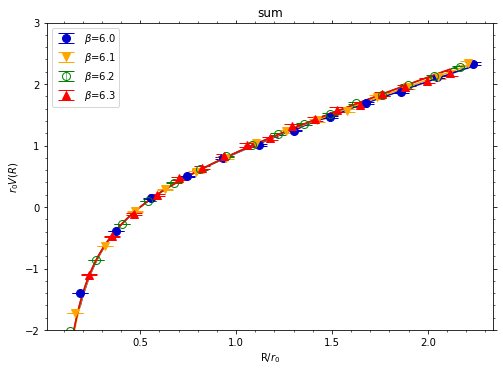

../../images/potential/together/su3/gluodynamics/beta_dependence/potential_mon_mod


In [142]:
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics'
size = '24^4'
params = 'steps_500/copies=3'
compensate = 'compensate_1'
r_max = 18
T_max = 11
y_lims = (-2, 3)
constraints = {'r/a': (1, r_max), 'T': (1, T_max)}
paths = [{'beta': 6.0, 'fit_range': (2, 12),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 12), 'T': (1, 12)}}, 
        'monopole': {'name' : 'mon', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 12), 'T': (1, 12)}}, 
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 12), 'T': (1, 12)}}}},
        {'beta': 6.1, 'fit_range': (2, 14),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 14), 'T': (1, 13)}}, 
        'monopole': {'name' : 'mon', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 14), 'T': (1, 13)}}, 
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 14), 'T': (1, 13)}}}},
        {'beta': 6.2, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}, 'fit_range': (2, 16),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 16), 'T': (1, 15)}}, 
        'monopole': {'name' : 'mon', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}}, 
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}}}},
        {'beta': 6.3, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}, 'fit_range': (2, 18),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 18), 'T': (1, 17)}}, 
        'monopole': {'name' : 'mon', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}}, 
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}}}}]
fit_range = (2, 12)
remove_from_plot = ['original', 'monopole', 'monopoless']
term = 'mon+mod'

potential_together_shifted(paths, f'../../images/potential/together/su3/gluodynamics/beta_dependence', f'potential_mon_mod', y_lims, False, remove_from_plot, False, term, 'sum')

5.367702622812138
SU3 [ 7.46324797e-05 -3.35192468e-01  4.65069380e-02]
[0.00112527 0.0016086  0.00017033]
6.336355747797897
SU3 [-0.00228358 -0.32820864  0.03341952]
[0.00231432 0.00346759 0.00031437]
7.382899148340123
SU3 [-0.00544294 -0.31899341  0.02488374]
[0.00083899 0.00137921 0.00010816]
8.513427304567733
SU3 [-0.00752557 -0.30920833  0.01883277]
[4.67066109e-04 7.45208912e-04 5.24307383e-05]


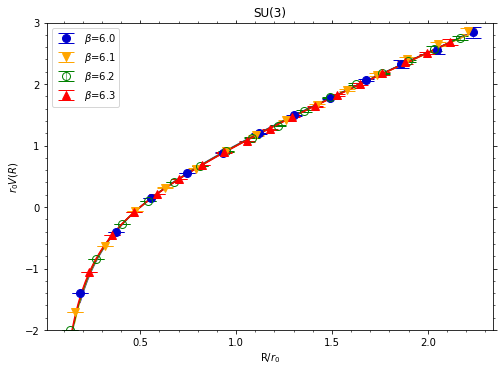

../../images/potential/together/su3/gluodynamics/beta_dependence/potential_original


In [143]:
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics'
size = '24^4'
params = 'steps_500/copies=3'
compensate = 'compensate_1'
r_max = 12
T_max = 11
y_lims = (-2, 3)
constraints = {'r/a': (1, r_max), 'T': (1, T_max)}
paths = [{'beta': 6.0, 'fit_range': (2, 12), 'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 12), 'T': (1, 11)}}}},
        {'beta': 6.1, 'fit_range': (2, 14), 'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 14), 'T': (1, 13)}}}},
        {'beta': 6.2, 'fit_range': (2, 16), 'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 16), 'T': (1, 15)}}}},
        {'beta': 6.3, 'fit_range': (2, 18), 'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 18), 'T': (1, 17)}}}}]
fit_range = (2, r_max)
remove_from_plot = []
term = 'SU3'

potential_together_shifted(paths, f'../../images/potential/together/su3/gluodynamics/beta_dependence', f'potential_original', y_lims, False, remove_from_plot, False, term, 'SU(3)')

aV(r)_SU2 0.09724598340307455 0.0024746015610866345 -0.2782058475791838 0.015848894736840338 0.001684471903558177 9.389510562535037e-05 chi_sq = -0.21935382387278998


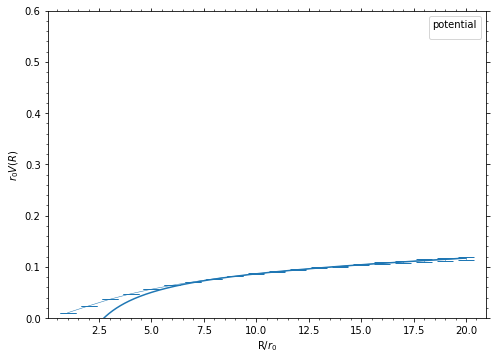

../../images/potential/decomposition/su2/qc2dstag/40^4/mu0.45/potential_fit


In [93]:
r_max = 20
constraints = {'r/a': (1, r_max)}
fit_range = (10, 20)
mu_arr = ['mu0.45']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_monopole.csv', 'T': 15, 'constraints': constraints, })
potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
r_max = 20
constraints = {'r/a': (1, r_max)}
fit_range = (5, 20)
mu_arr = ['mu0.35']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_monopole.csv', 'T': 15, 'constraints': constraints, })
potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
r_max = 20
constraints = {'r/a': (1, r_max)}
fit_range = (3, 11)
mu_arr = ['mu0.35']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': constraints, })
potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
r_max = 20
constraints = {'r/a': (1, r_max)}
fit_range = (5, 17)
mu_arr = ['mu0.00', 'mu0.05', 'mu0.20', 'mu0.25', 'mu0.30', 'mu0.35', 'mu0.40', 'mu0.45']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': constraints})
potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
r_max = 17
constraints = {'r/a': (1, r_max)}
fit_range = (8, r_max)
mu_arr = ['mu0.40', 'mu0.45']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': constraints})
potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
def make_plot_decomposition_su2(path1, size, beta, beta_str, params, compensate, r_max, y_lims):
    r_max = 20
    beta1 = beta_str.replace('.', 'p')
    path = f'{path1}/{size}/{beta_str}'
    constraints = {'r/a': (1, r_max)}
    paths = {'original': {'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': constraints}, 
            'monopole': {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 8, 'constraints': constraints}, 
            'monopoless': {'name' : 'mod', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': constraints},
            'abelian': {'name' : 'abel', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential/potential_abelian.csv', 'T' : 8}, 
            'offdiagonal': {'name' : 'offdiag', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_offdiagonal.csv', 'T' : 8}}
    r0 = 1
    fit_range = (2, r_max)
    remove_from_plot = []
    potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
#     remove_from_plot = ['monopole', 'monopoless']
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
#     paths = {'original': {'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'T': 6, 'constraints': constraints}, 
#             'monopole': {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 12, 'constraints': constraints}, 
#             'monopoless': {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': constraints}}
#     remove_from_plot = []
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)

In [ ]:
make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.6, 'beta2.6', 'T_step=0.01', '/', 24, (-0.03, 0.75))

In [ ]:
params = ['T_step=0.0001', 'T_step=0.0002', 'T_step=0.0004', 'T_step=0.0008', 'T_step=0.0016', 'T_step=0.0032']
for p in params:
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.7, 'beta2.7', p, '/', 24, (-0.03, 0.61))

In [ ]:
params = ['T_step=0.0001', 'T_step=0.0002', 'T_step=0.0004', 'T_step=0.0008', 'T_step=0.001', 'T_step=0.002', 'T_step=0.004', 'T_step=0.008', 'T_step=5e-05']
for p in params:
    print(p)
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.8, 'beta2.8', p, '/', 24, (-0.03, 0.61))

In [ ]:
params = ['T_step=0.0001', 'T_step=0.0002', 'T_step=0.0004', 'T_step=0.0008', 'T_step=0.0016', 'T_step=0.0032']
for p in params:
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.6, 'beta2.7', p, '/', 24, (-0.03, 0.61))

In [ ]:
for mu in ['mu0.00', 'mu0.05', 'mu0.20', 'mu0.25', 'mu0.35', 'mu0.40', 'mu0.45']:
    print(mu)
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/qc2dstag', '40^4', 1, mu, '/', '/', 20, (-0.4, 0.6))

In [ ]:
def make_plot_decomposition(path1, size, beta, beta_str, params, compensate, r_max, T_max, y_lims):
    beta1 = beta_str.replace('.', 'p')
    path = f'{path1}/{size}/{beta_str}'
    constraints = {'r/a': (1, r_max), 'T': (1, T_max)}
    paths = {'original': {'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': constraints}, 
            'monopole': {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': constraints}, 
            'monopoless': {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': constraints},
            'abelian': {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential/potential_abelian.csv', 'T' : 8}, 
            'offdiagonal': {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_offdiagonal.csv', 'T' : 6}}
    r0 = get_r0(beta)
    fit_range = (2, r_max)
    remove_from_plot = []
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
    remove_from_plot = ['monopole', 'monopoless']
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
    paths = {'original': {'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': constraints}, 
            'monopole': {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': constraints}, 
            'monopoless': {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': constraints}}
    remove_from_plot = []
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
    potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)

In [ ]:
a = {}
for beta in [6, 6.1, 6.2, 6.3]:
    a[beta] = 1/ get_r0(beta)
print(a)

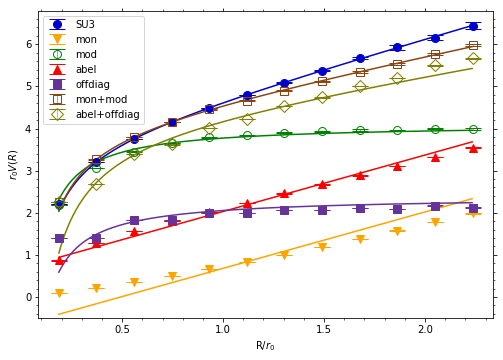

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0


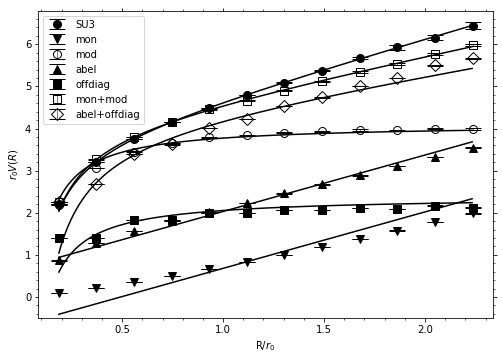

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0_black


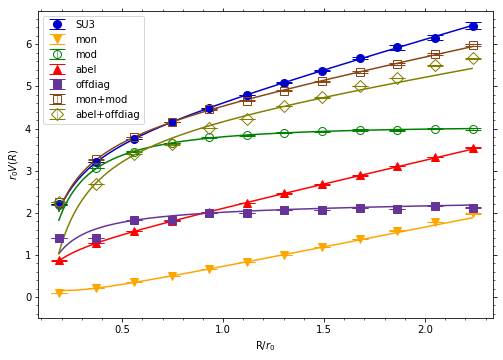

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0


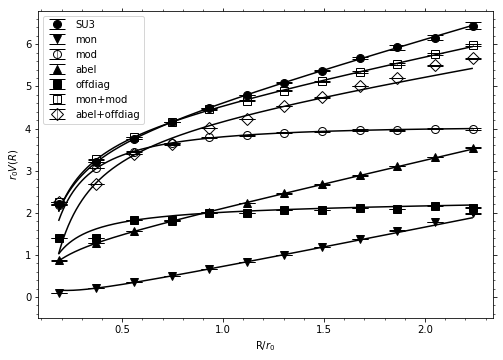

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0_black


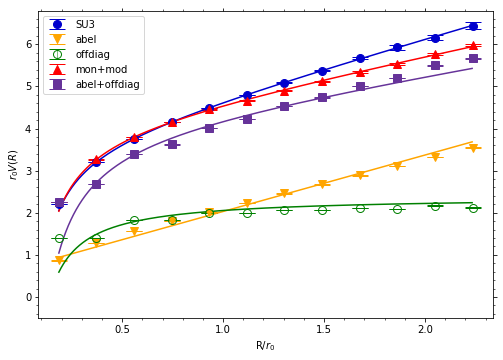

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0


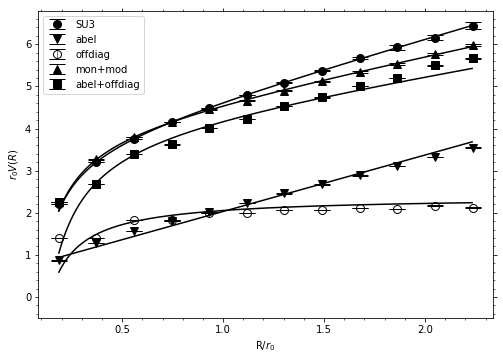

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0_black


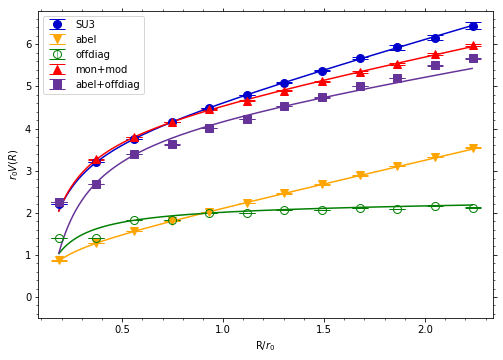

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0


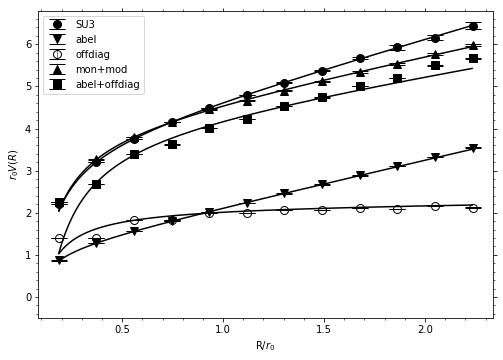

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0_black


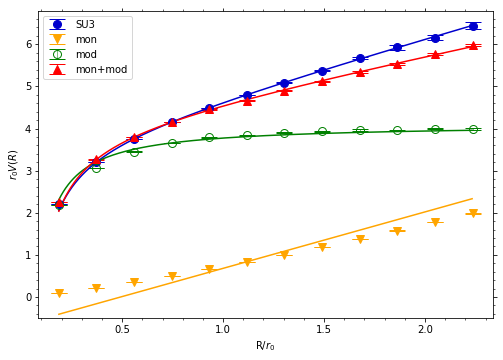

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0


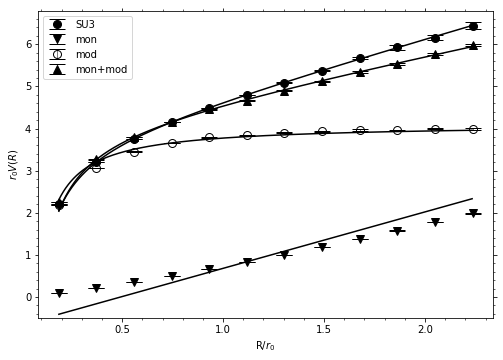

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0_black


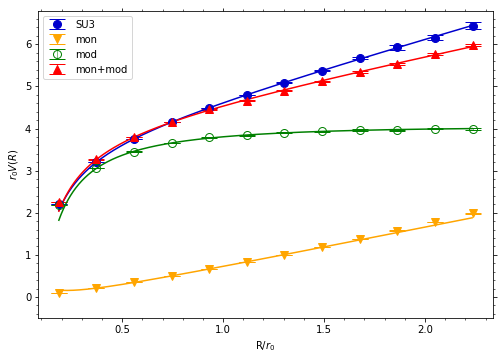

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0


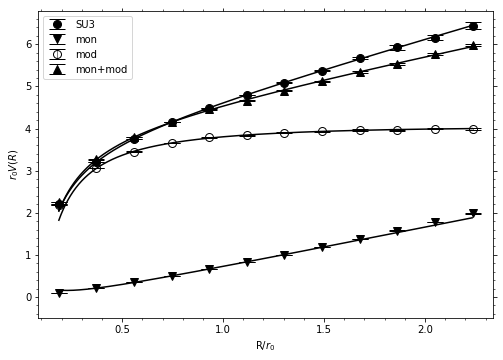

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0_black


In [6]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_500/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

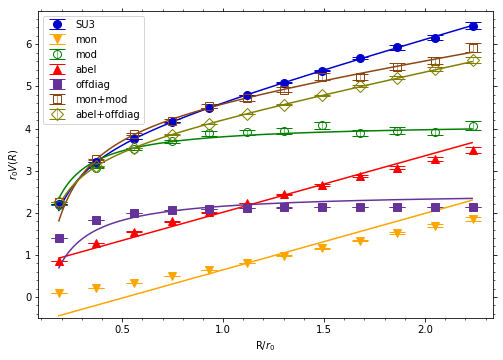

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0


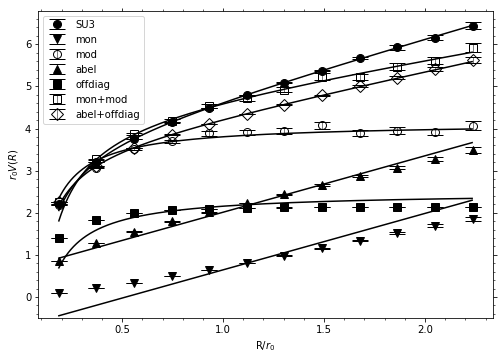

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0_black


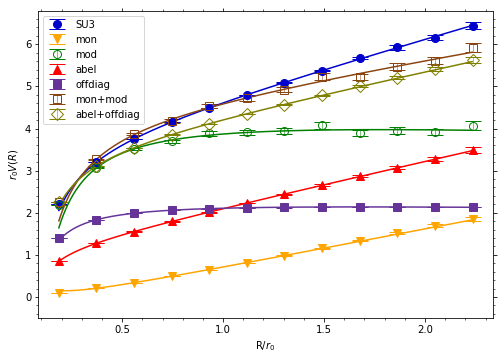

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0


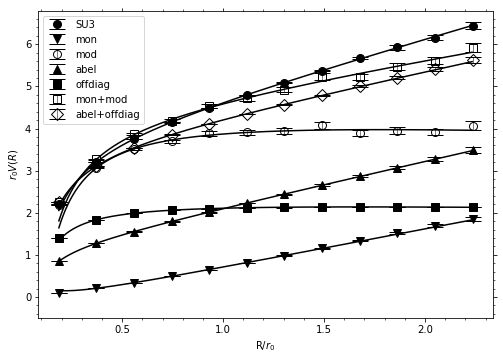

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0_black


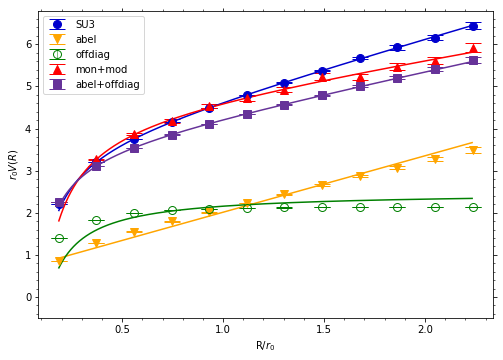

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0


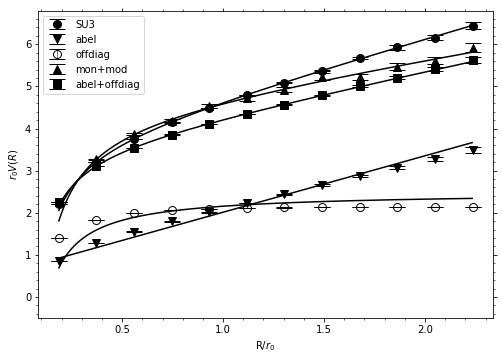

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0_black


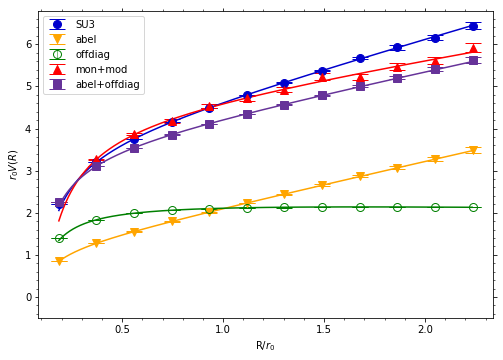

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0


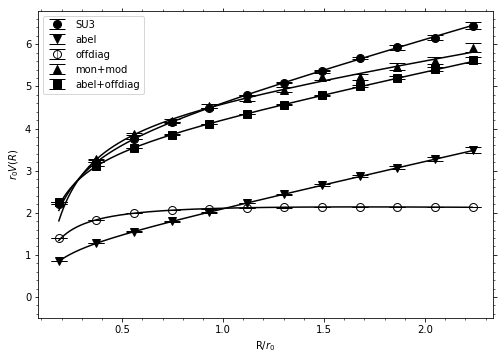

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0_black


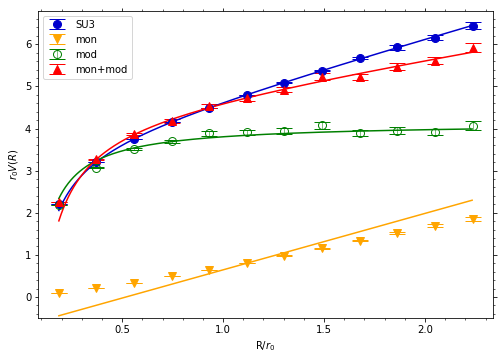

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0


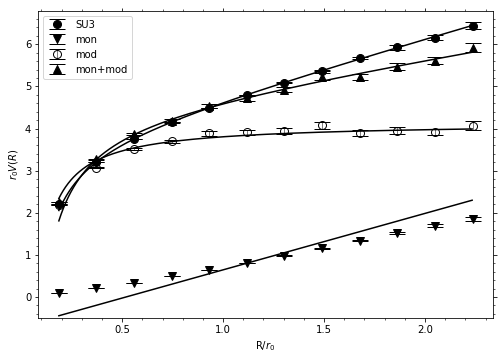

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0_black


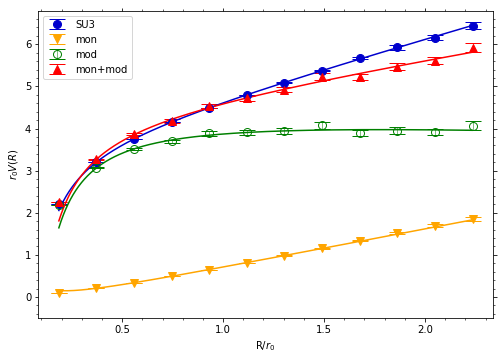

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0


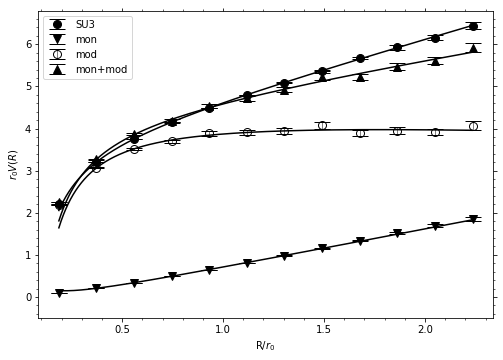

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0_black


In [7]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_1000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

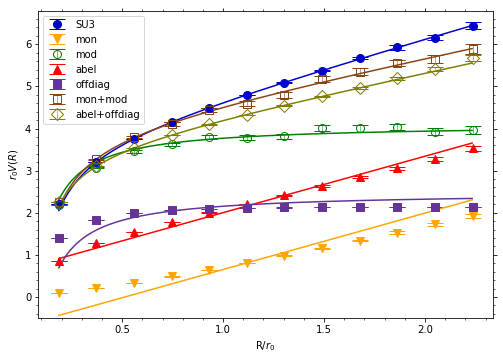

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0


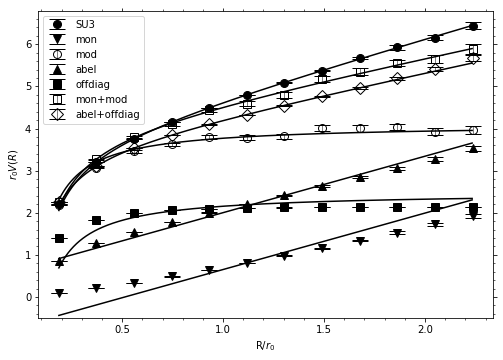

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0_black


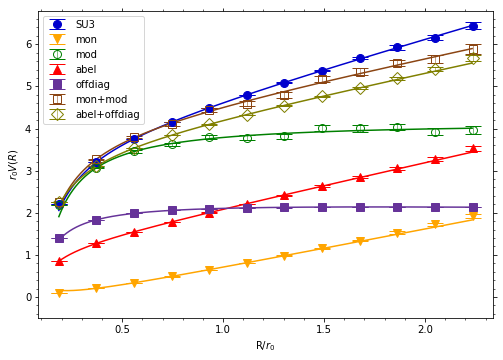

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0


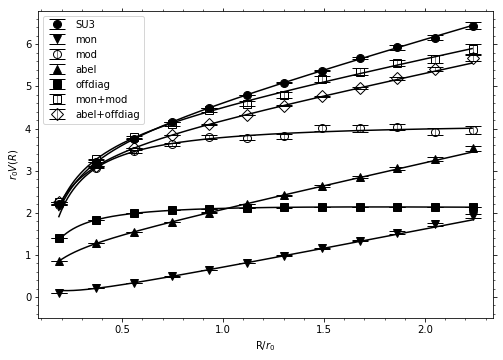

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0_black


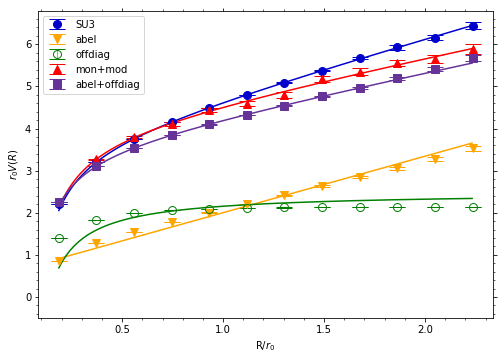

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0


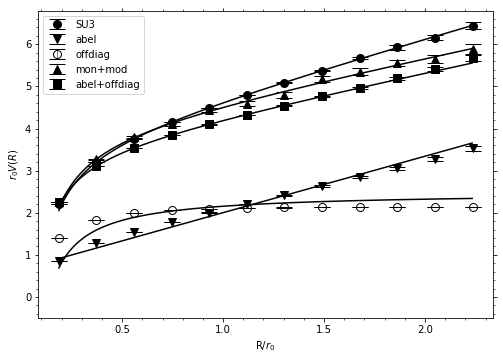

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0_black


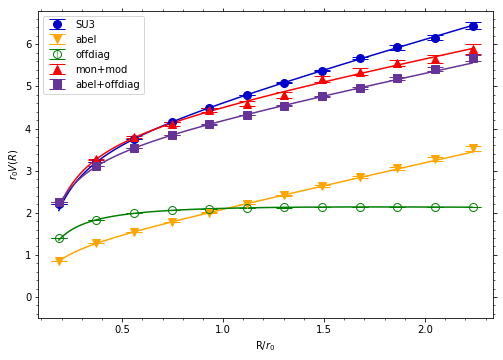

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0


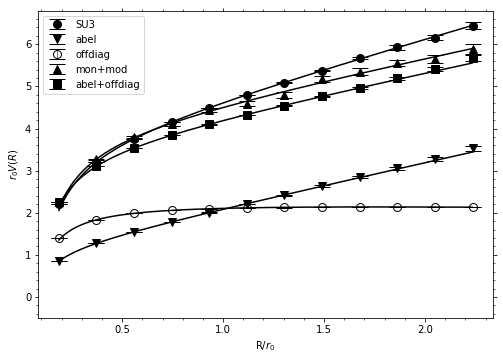

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0_black


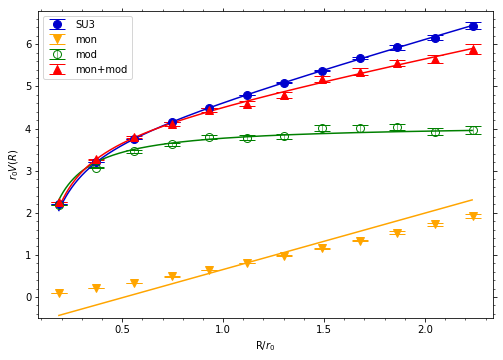

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0


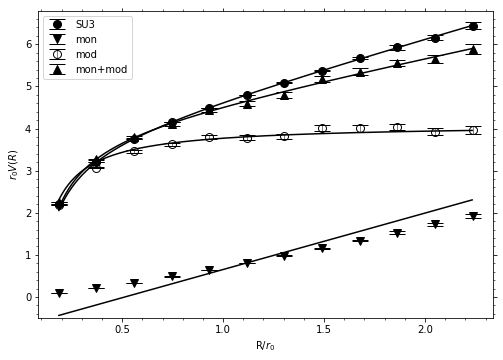

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0_black


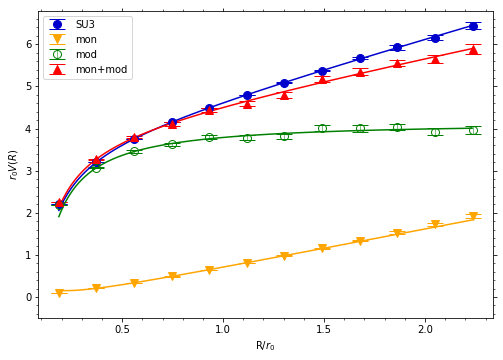

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0


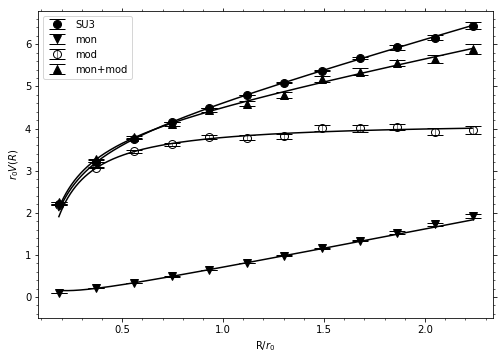

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0_black


In [8]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_2000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

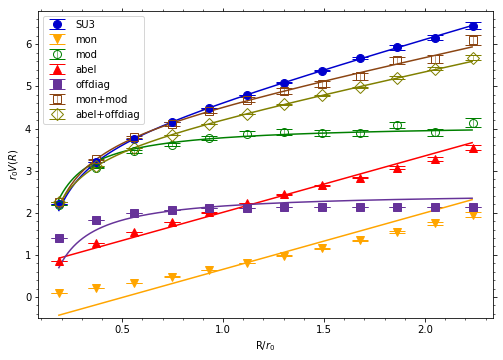

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0


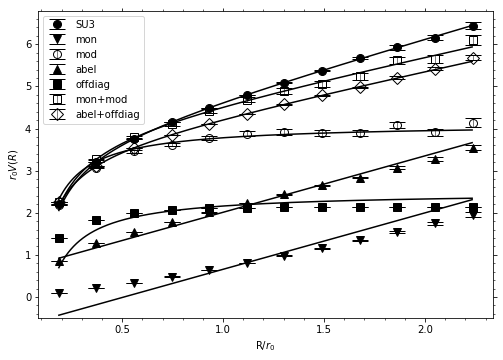

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0_black


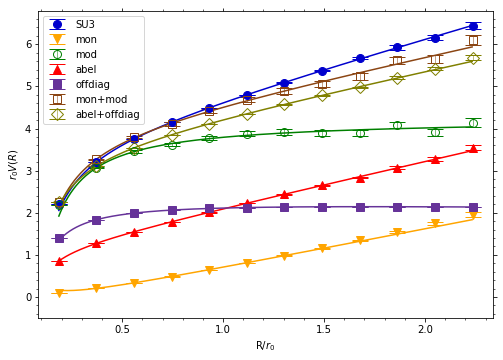

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0


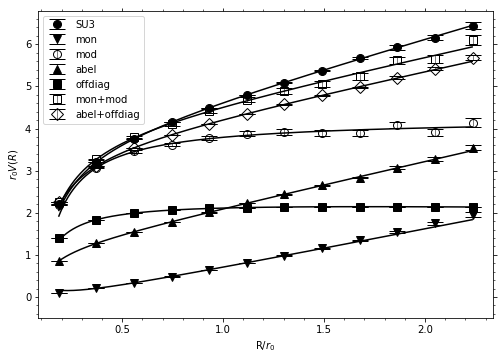

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0_black


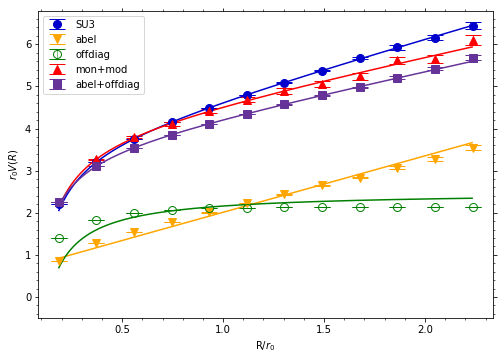

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0


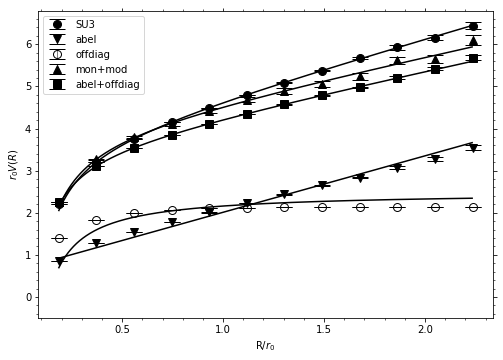

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0_black


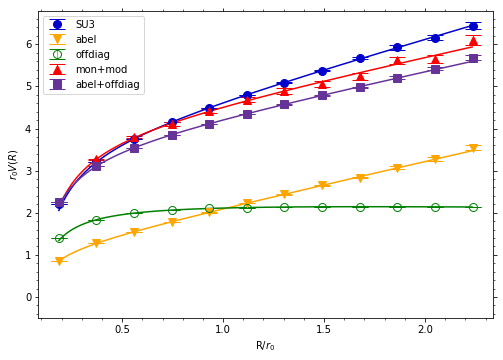

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0


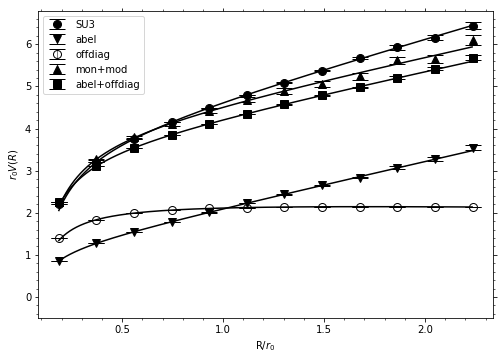

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0_black


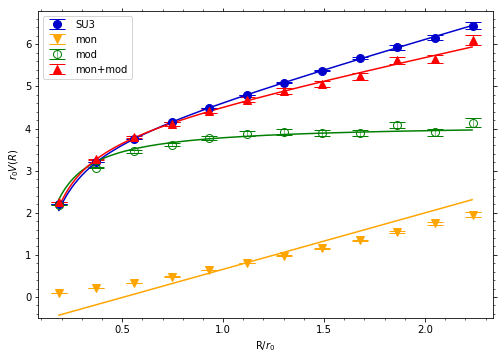

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0


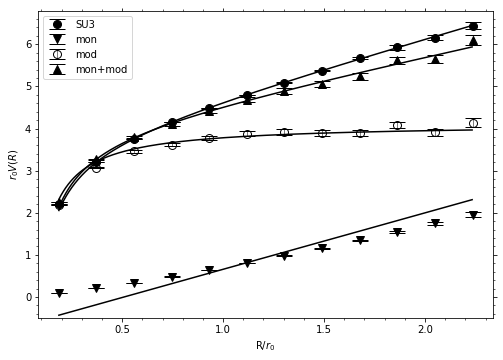

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0_black


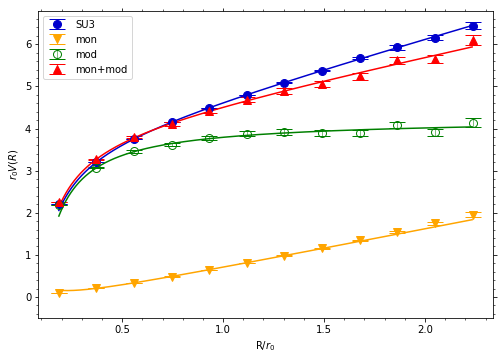

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0


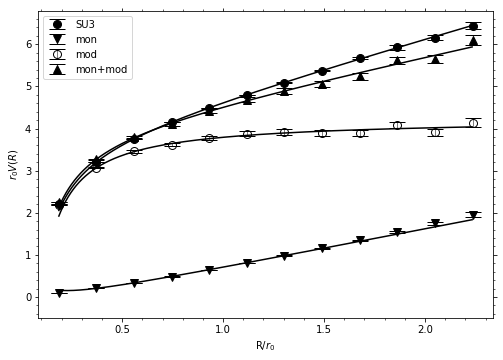

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0_black


In [9]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_4000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

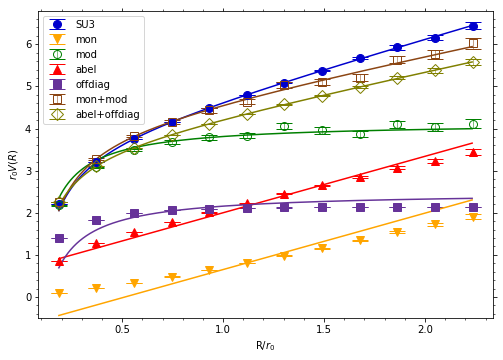

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0


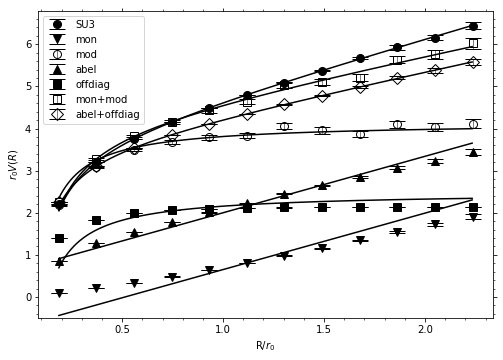

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_from_original_24^4_beta6p0_black


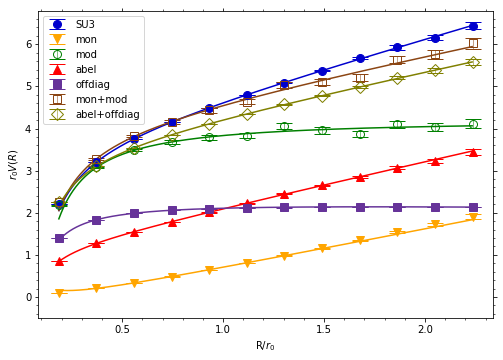

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0


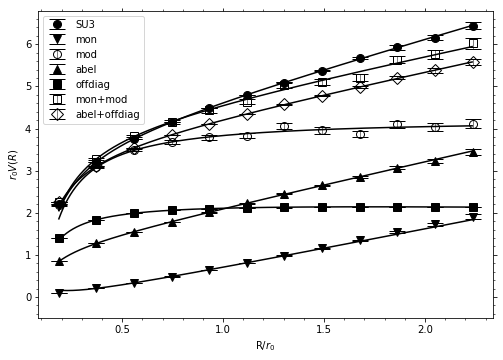

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_fit_separate_24^4_beta6p0_black


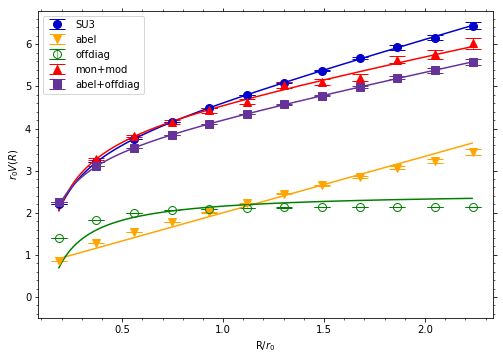

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0


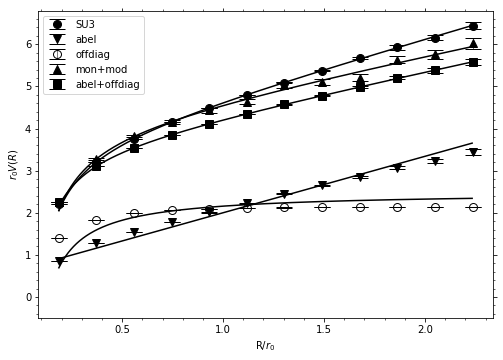

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_from_original_24^4_beta6p0_black


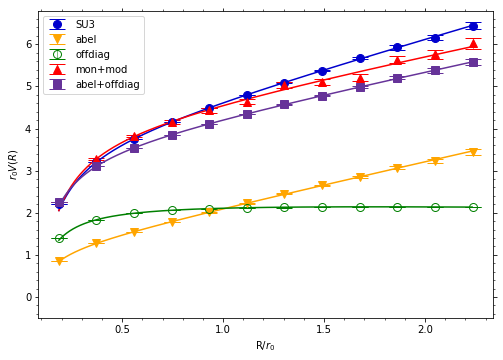

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0


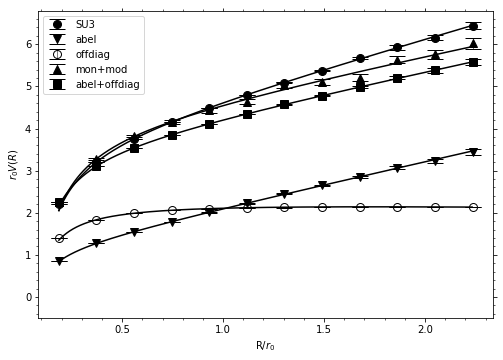

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_full_mon_mod_removed_fit_separate_24^4_beta6p0_black


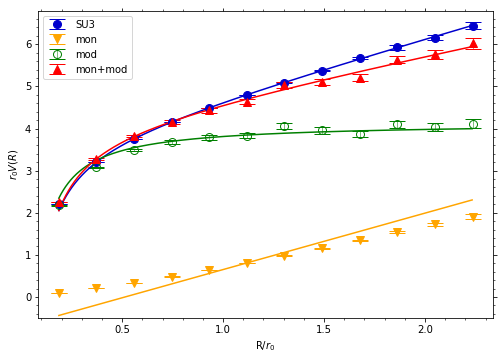

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0


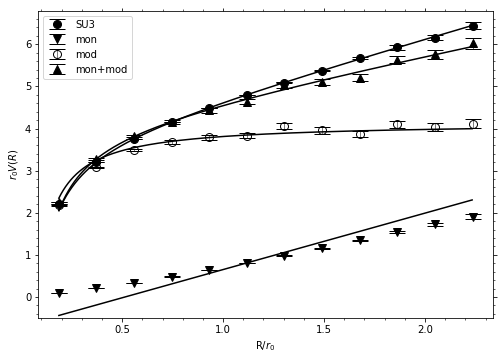

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_from_original_24^4_beta6p0_black


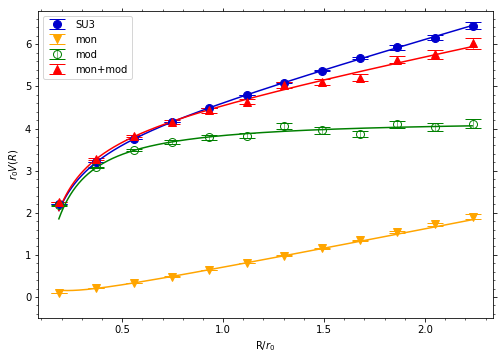

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0


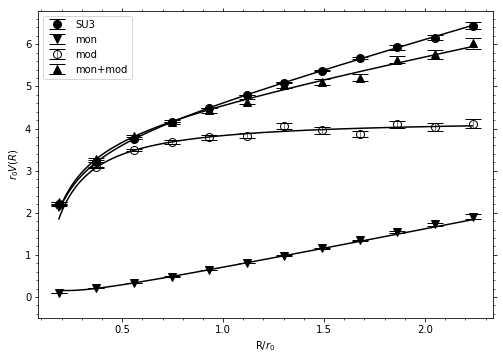

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_mon_mod_fit_separate_24^4_beta6p0_black


In [10]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_8000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

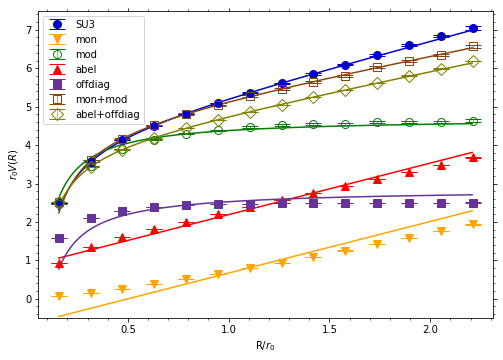

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_fit_from_original_28^4_beta6p1


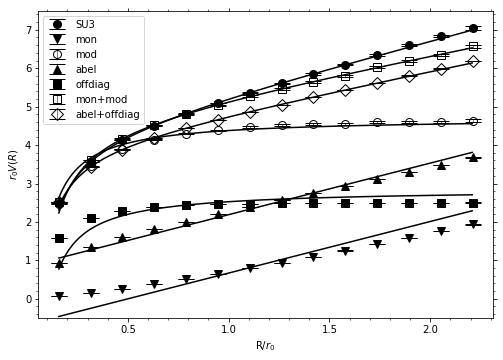

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_fit_from_original_28^4_beta6p1_black


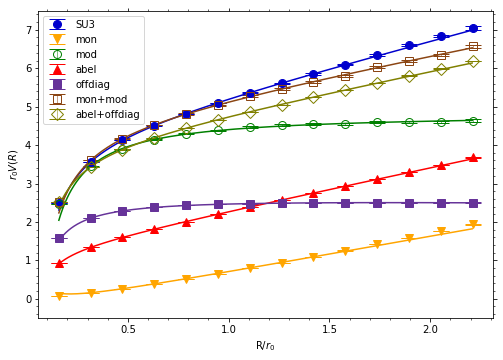

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_fit_separate_28^4_beta6p1


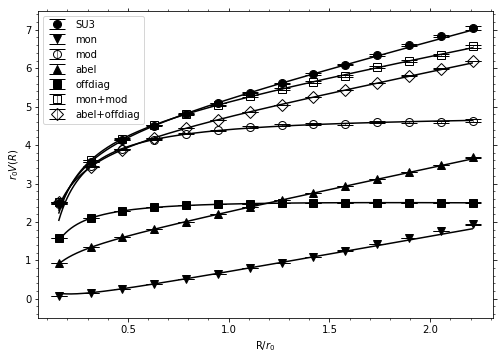

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_fit_separate_28^4_beta6p1_black


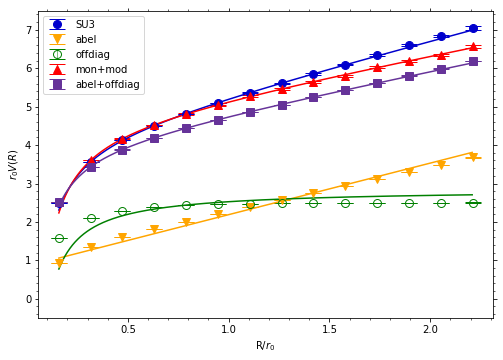

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_mon_mod_removed_fit_from_original_28^4_beta6p1


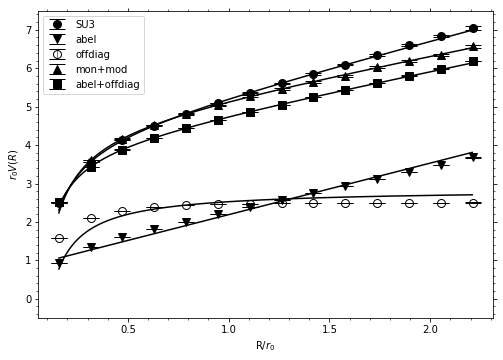

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_mon_mod_removed_fit_from_original_28^4_beta6p1_black


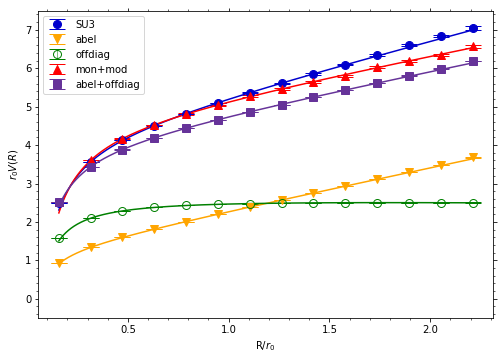

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_mon_mod_removed_fit_separate_28^4_beta6p1


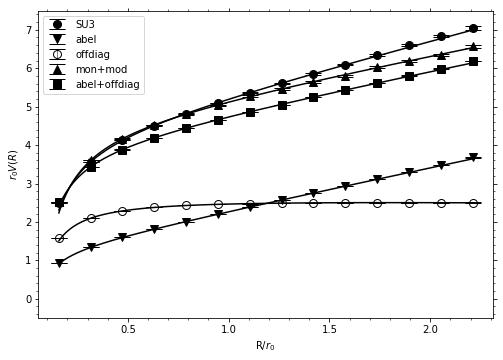

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_full_mon_mod_removed_fit_separate_28^4_beta6p1_black


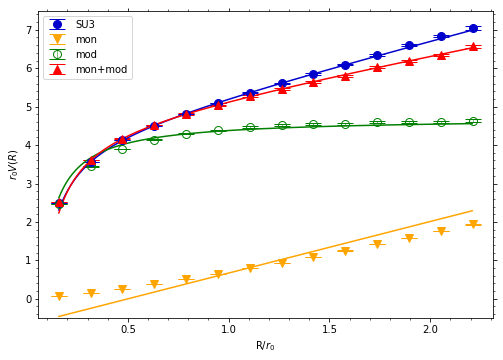

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_mon_mod_fit_from_original_28^4_beta6p1


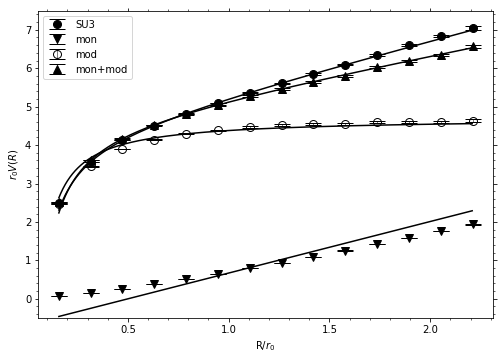

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_mon_mod_fit_from_original_28^4_beta6p1_black


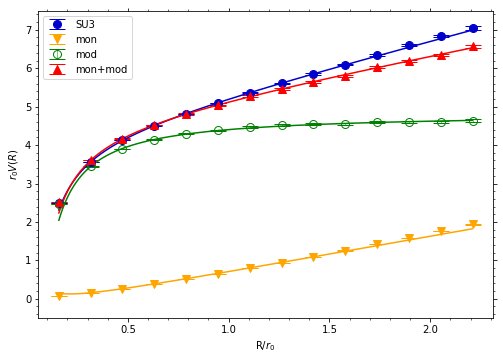

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_mon_mod_fit_separate_28^4_beta6p1


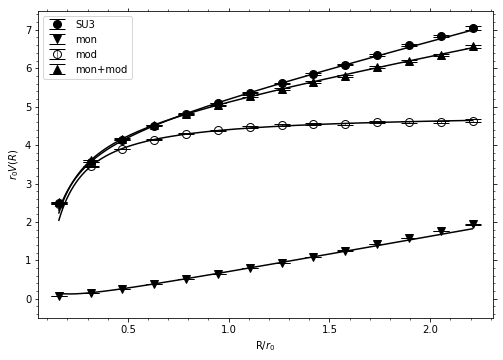

../../images/potential/decomposition/su3/gluodynamics/28^4/beta6.1/potential_decomposition_mon_mod_fit_separate_28^4_beta6p1_black


In [11]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '28^4', 6.1, 'beta6.1', 'steps_500/copies=3', 'compensate_1', 14, 14, (-0.5, 7.5))

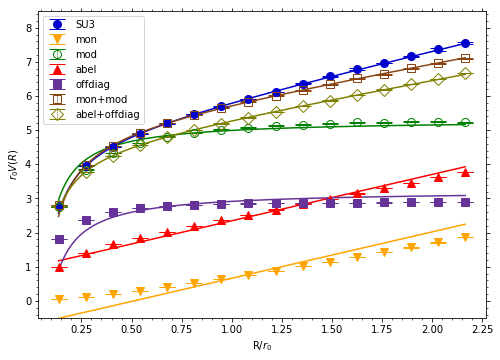

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_fit_from_original_32^4_beta6p2


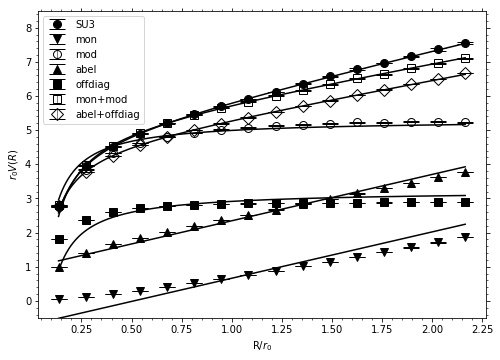

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_fit_from_original_32^4_beta6p2_black


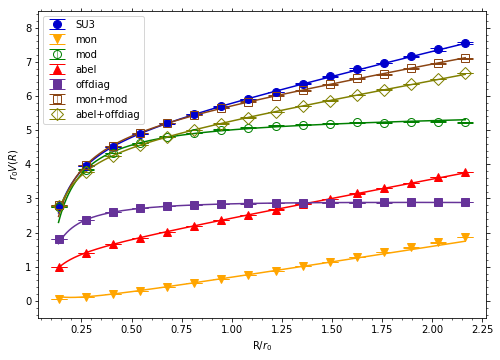

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_fit_separate_32^4_beta6p2


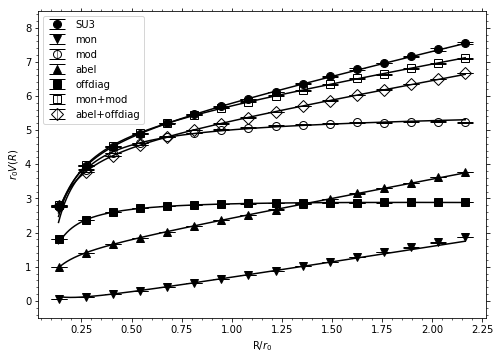

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_fit_separate_32^4_beta6p2_black


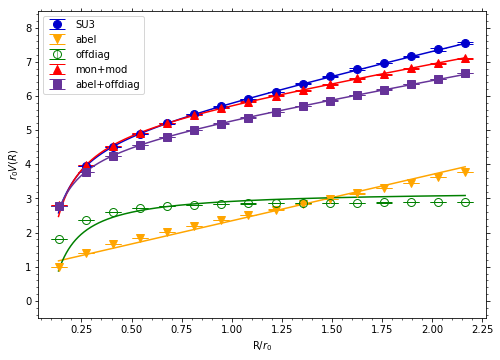

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_mon_mod_removed_fit_from_original_32^4_beta6p2


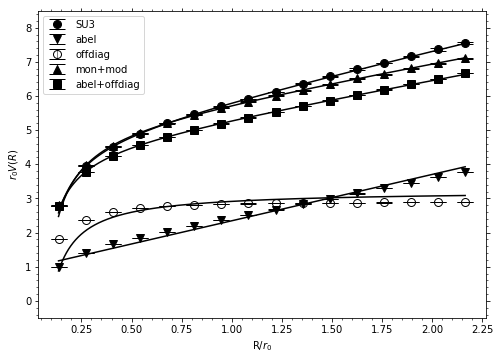

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_mon_mod_removed_fit_from_original_32^4_beta6p2_black


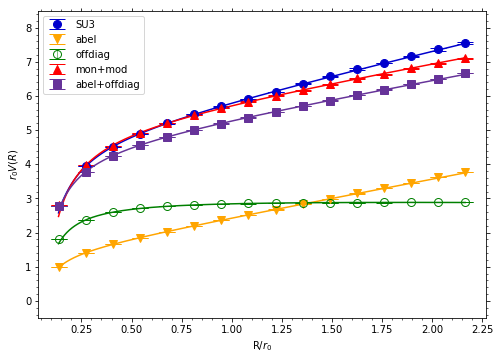

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_mon_mod_removed_fit_separate_32^4_beta6p2


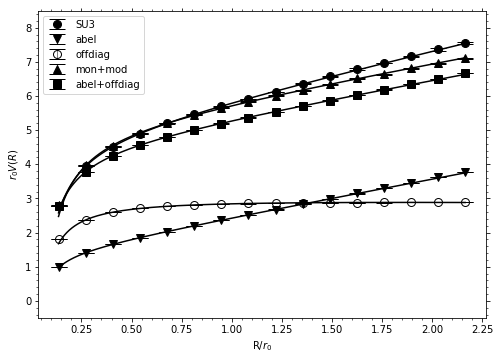

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_full_mon_mod_removed_fit_separate_32^4_beta6p2_black


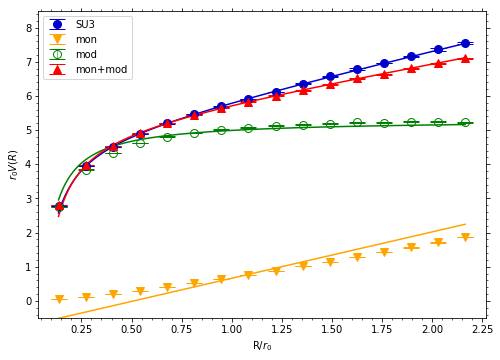

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_mon_mod_fit_from_original_32^4_beta6p2


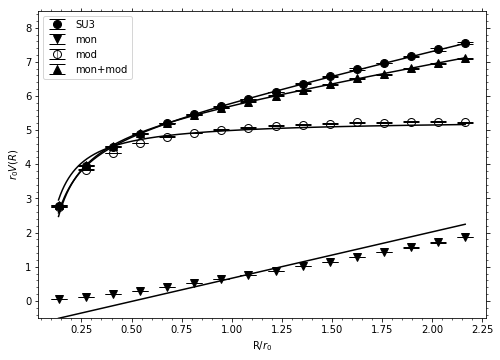

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_mon_mod_fit_from_original_32^4_beta6p2_black


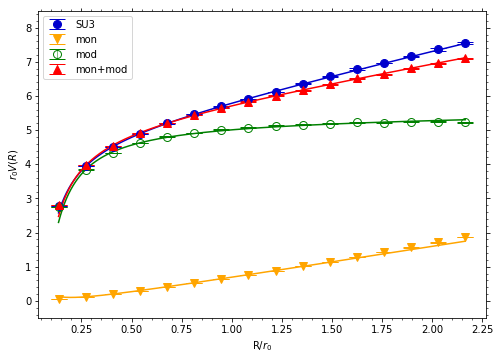

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_mon_mod_fit_separate_32^4_beta6p2


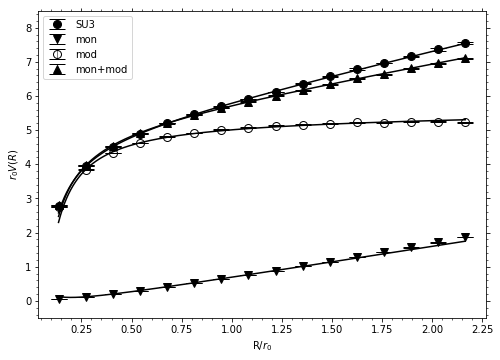

../../images/potential/decomposition/su3/gluodynamics/32^4/beta6.2/potential_decomposition_mon_mod_fit_separate_32^4_beta6p2_black


In [13]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '32^4', 6.2, 'beta6.2', 'steps_500/copies=3', 'compensate_1', 16, 16, (-0.5, 8.5))

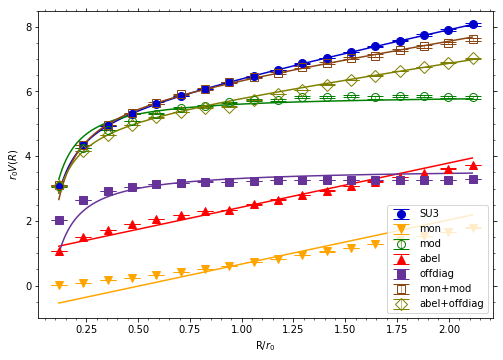

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_fit_from_original_36^4_beta6p3


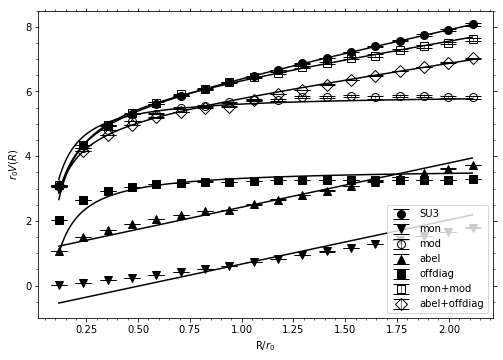

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_fit_from_original_36^4_beta6p3_black


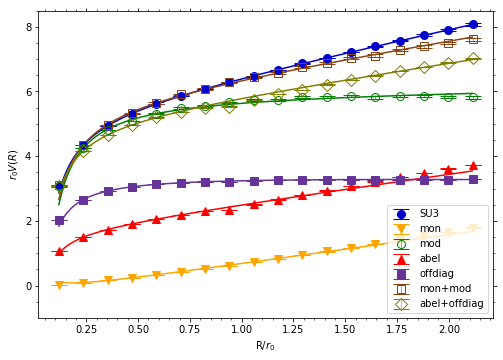

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_fit_separate_36^4_beta6p3


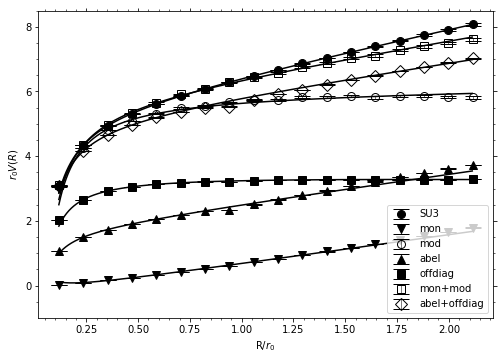

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_fit_separate_36^4_beta6p3_black


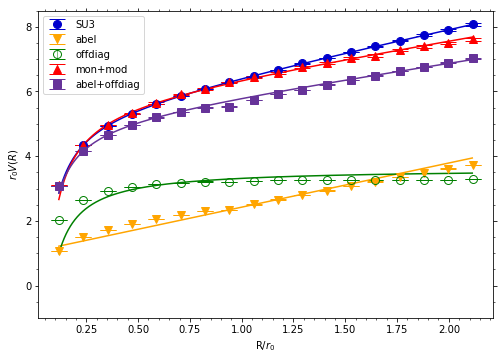

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_mon_mod_removed_fit_from_original_36^4_beta6p3


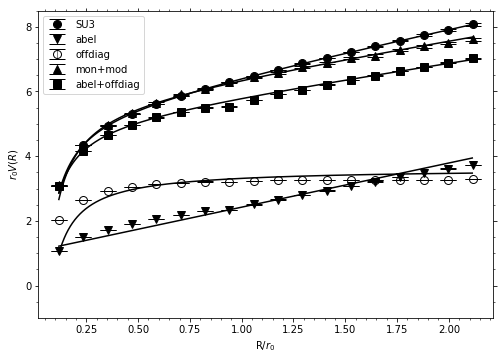

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_mon_mod_removed_fit_from_original_36^4_beta6p3_black


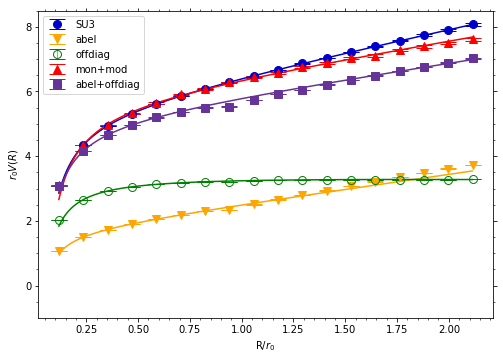

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_mon_mod_removed_fit_separate_36^4_beta6p3


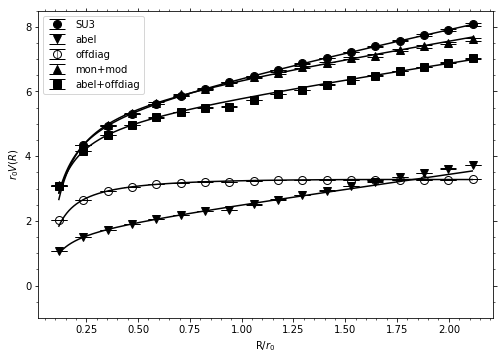

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_full_mon_mod_removed_fit_separate_36^4_beta6p3_black


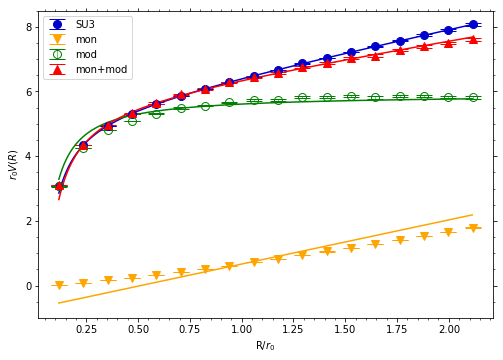

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_mon_mod_fit_from_original_36^4_beta6p3


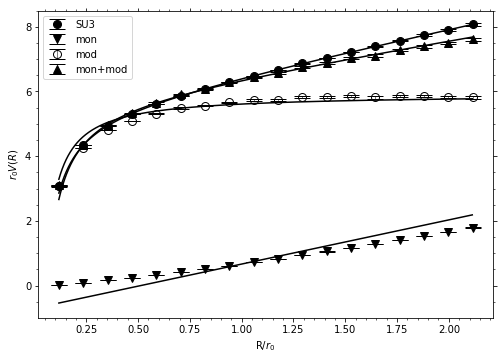

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_mon_mod_fit_from_original_36^4_beta6p3_black


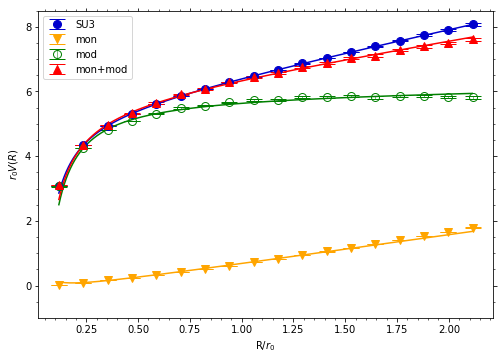

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_mon_mod_fit_separate_36^4_beta6p3


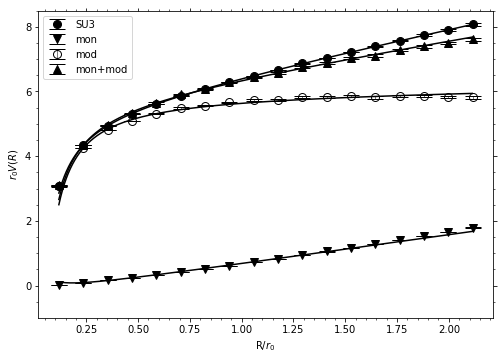

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_mon_mod_fit_separate_36^4_beta6p3_black


In [14]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_500/copies=3', 'compensate_1', 18, 16, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_1000/copies=3', 'compensate_1', 18, 17, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_2000/copies=3', 'compensate_1', 18, 17, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_4000/copies=3', 'compensate_1', 18, 17, (-1, 8.5))

In [ ]:
fit_coefs = {'SU(3)': (3.611, -0.337, 1.343),
                'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_abel_offdiag_mon+mod_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
to_fit = ['abel', 'offdiag', 'abel+offdiag']
to_remove = ['mon', 'mod']
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8}, 
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_general(paths, path, image_path, image_name, fit_coefs, to_fit, to_remove, terms, y_lims, beta, 12)

In [ ]:
fit_coefs = {'SU(3)': (3.611, -0.337, 1.343)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_abel_offdiag_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
to_fit = ['abel', 'offdiag', 'abel+offdiag']
to_remove = ['mon', 'mod', 'mon+mod']
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8}, 
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_general(paths, path, image_path, image_name, fit_coefs, to_fit, to_remove, terms, y_lims, beta, 12)

In [ ]:
fit_coefs = {'SU(3)': (3.611, -0.337, 1.343),
        'mon': (-0.365, 0.0887, 0.993),
        'mod': (4.222, -0.424, 0),
        'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_full_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
to_fit = ['abel', 'offdiag', 'abel+offdiag']
to_remove = []
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8}, 
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_general(paths, path, image_path, image_name, fit_coefs, to_fit, to_remove, terms, y_lims, beta, 12)

In [ ]:
coefs = {'SU(3)': (3.611, -0.337, 1.343),
        'mon': (-0.365, 0.0887, 0.993),
        'mod': (4.222, -0.424, 0),
        'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_mon_mod_abel+offdiag_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8}, 
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_vitaly1(paths, path, image_path, image_name, coefs, terms, y_lims, beta, 12)

In [ ]:
coefs = {'SU(3)': (3.611, -0.337, 1.343),
        'mon': (-0.365, 0.0887, 0.993),
        'mod': (4.222, -0.424, 0),
        'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_mon_mod_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
y_lims = (-0.5, 6.8)
beta = 6.0
potential_decomposition_vitaly(path, image_path, image_name, coefs, terms, y_lims, beta)

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv'}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_fit_original_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'original')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_fit_separate_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6}, 
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})

potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_fit_original_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'original')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6}, 
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_fit_separate_24^4_beta6p0', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/36^4/beta6.3'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition_fit_separate_36^4_beta6p3', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/36^4/beta6.3'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6}, 
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition1_fit_separate_36^4_beta6p3', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta2.5', 'potential_decomposition_24^4_beta2p5', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_abelian.csv', 'T' : 6}, 
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta2.5', 'potential_decomposition1_24^4_beta2p5', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta5.5', 'potential_decomposition_24^4_beta2p5', 
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5}, 
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12}, 
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_24^4_beta6p0', 1, 6.0, 12)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/24^4/beta2.4'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 4, 100), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopole.csv', 6, 80), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopoless.csv', 6, 80)}
potential_decomposition(paths, f'../images/potential/decomposition/qc2dstag', 'potential_qc2dstag_mu00', 1, 12)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.7'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 400), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 400)}
potential_decomposition(paths, f'../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p7', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 300), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p001', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopole.csv', 16, 30), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0005', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 200), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0001', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopole.csv', 6, 400), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopoless.csv', 8, 400)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_5e-05', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 8, 360), 
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopole.csv', 23, 400), 
        'monless': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopoless.csv', 16, 400)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_5e-05', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 5, 600), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopoless.csv', 5, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 5, 600), 
        'monless': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopoless.csv', 5, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_offdiagonal.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition1_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600), 
        'abel': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'offdiag': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_offdiagonal.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition1_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 6, 600), 
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_photon.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition2_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'abel': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600), 
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 6, 600), 
        'phot': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_photon.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition2_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 12), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 8)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_24^4_beta6p0', 1, 6.0, 12)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6), 
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 6), 
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 6)}

potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_24^4_beta6p0', 1, 12)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 6), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 6), 
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_photon.csv', 6)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition2_24^4_beta6p0', 1, 12)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3_HYP0': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6), 
         'su3_HYP1': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6)}
potentials_together(paths, 1, 12)

In [ ]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 7), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 18), 
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 7)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition_36^4_beta6p3', 1, 18)

In [ ]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 7), 
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 12), 
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 12)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition1_36^4_beta6p3', 1, 18)

In [ ]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 12), 
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 12), 
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_photon.csv', 12)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition2_36^4_beta6p3', 1, 18)

In [ ]:
def plot_time_dependence(path, space_size, T_max, image_path, image_name):
    df_data = pd.read_csv(path, index_col=None)
    
    df_data = df_data[df_data['r/a'] == space_size]
    df_data = df_data[df_data['T'] <= T_max]
    fg = seaborn.FacetGrid(data=df_data, height=3.5, aspect=1.61)
    fg.fig.suptitle(f'r={space_size}')
    fg.map(plt.errorbar, 'T', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()
    
    plt.show()

    save_image(image_path, image_name, fg)
    
def plot_time_dependence_space(mu, monopole, smearing, lattice_size):
    df_data_40_5 = pd.read_csv(f"../result/potential_spatial/{monopole}/qc2dstag/{lattice_size}/potential_spatial_mu=0.{mu}.csv", index_col=None)
    
    time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
    
    df1 = df_data_40_5[df_data_40_5['T'].isin(time_sizes)]
    fg = seaborn.FacetGrid(data=df1, hue='T',  aspect=1.61)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'../images/potential_spatial/qc2dstag/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/potential_space_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [ ]:
def make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate):
    print('original')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/potential/potential_original.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}'
        image_name = f'potential_time_original_r={r}'
        plot_time_dependence(path, r, T_max_arr[0], image_path, image_name)
    print('monopole')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_monopole.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_monopole_r={r}'
        plot_time_dependence(path, r, T_max_arr[1], image_path, image_name)
    print('monopoless')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_monopoless.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_monopoless_r={r}'
        plot_time_dependence(path, r, T_max_arr[2], image_path, image_name)
    print('abelian')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/potential/potential_abelian.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}'
        image_name = f'potential_time_abelian_r={r}'
        plot_time_dependence(path, r, T_max_arr[3], image_path, image_name)
    print('offdiagonal')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_offdiagonal.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_offdiagonal_r={r}'
        plot_time_dependence(path, r, T_max_arr[4], image_path, image_name)
    print('photon')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_photon.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_photon_r={r}'
        plot_time_dependence(path, r, T_max_arr[5], image_path, image_name)

In [ ]:
common_path = 'su2/qc2dstag/40^4/mu0.00/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [8, 20, 8, 8, 8, 8]
space_sizes = [2, 4, 8, 12, 16, 20]
compensate = ''
additional_parameters = '/'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su2/su2_suzuki/48^4/beta2.8/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [8, 8, 8, 8, 8, 8]
space_sizes = [2, 4, 8, 12, 16, 20, 24]
compensate = ''
additional_parameters = 'T_step=0.0001'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [10, 18, 12, 18, 18, 18]
space_sizes = [2, 4, 8, 12, 16, 20, 24, 30, 36]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [10, 18, 12, 18, 18, 18]
space_sizes = [2, 4, 8, 12, 16, 20, 24, 30, 36]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [7, 24, 12, 16, 16, 24]
space_sizes = [2, 4, 8, 10, 11, 12]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [12, 18, 12, 24, 24, 24]
space_sizes = [2, 4, 8, 12, 16, 20, 24]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
plot_time_dependence('05', 'monopole', '40^4', 'smeared')
plot_time_dependence('35', 'monopole', '40^4')
plot_time_dependence('45', 'monopole', '40^4')

In [ ]:
plot_time_dependence('05', 'monopoless', '40^4')
plot_time_dependence('35', 'monopoless', '40^4')
plot_time_dependence('45', 'monopoless', '40^4')

In [ ]:
plot_time_dependence('05', '', '40^4', 'smeared')
plot_time_dependence('35', '', '40^4', 'smeared')
plot_time_dependence('45', '', '40^4', 'smeared')

In [ ]:
plot_time_dependence('05', '', '40^4', 'unsmeared')

In [ ]:
plot_time_dependence('00', 'monopole', '32^4', 'unsmeared')
plot_time_dependence('00', 'monopoless', '32^4', 'smeared')
plot_time_dependence('00', '', '32^4', 'smeared')

In [ ]:
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '1')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '2')

In [ ]:
plot_time_dependence_space('05', '', '', '40^4')

In [ ]:
def plot_time_dependence_several_sizes(mu, monopole, lattice_size, smearing, space_sizes, statistics_type):
    df_data = pd.read_csv(f"../result/potential/on-axis/{monopole}/qc2dstag/{smearing}/{lattice_size}/potential_mu=0.{mu}.csv", index_col=None)
    
#     time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
#     space_sizes = [1, 2, 3]
    
    df1 = df_data[df_data['r/a'].isin(space_sizes)]
    df1 = df1[df1['T'] <= 16]
    fg = seaborn.FacetGrid(data=df1, hue='r/a',  aspect=1.61)
    fg.map(plt.errorbar, 'T', f'aV{statistics_type}(r)', f'err{statistics_type}', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'../images/potential/on-axis/qc2dstag/{smearing}/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/potential_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [ ]:
space_sizes = [[1], [6], [10], [14], [18]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('05', '', '40^4', 'smeared', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '1')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '2')

In [ ]:
from scipy.optimize import curve_fit

def make_potential_trunin(data, df1, df, time_size_max):
   
    time_size = data["T"].iloc[0]
    space_size = data["r/a"].iloc[0]

    if time_size < time_size_max:

        wilson_loop_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop'].values[0]
        wilson_loop_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop'].values[0]

        wilson_loop_err_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]
        wilson_loop_err_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]

        try:
            new_row = {'aV(r)': math.log(wilson_loop_T/wilson_loop_T1), 'err': math.sqrt(wilson_loop_err_T ** 2 / wilson_loop_T1 ** 2 + wilson_loop_err_T1 ** 2 * wilson_loop_T ** 2 / wilson_loop_T1 ** 4)}

            df1 = df1.append(new_row, ignore_index=True)

            return df1
        except ValueError:
            return df1

def plots_T(data, fit_start, fit_end, procedure, T_lim):

    x = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['T'].to_numpy()
    y = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['aV(r)'].to_numpy()

    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'T', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    if procedure == 'fitting':
        popt, pcov = curve_fit(func_exponent, x, y)

        x1 = np.arange(x.min(), x.max(), 0.01)
        y1 = func_exponent(x1, popt[0], popt[1], popt[2])

        plt.plot(x1, y1)

    plt.show()

    if procedure == 'fitting':
        return pd.Series([popt[0], math.sqrt(pcov[0][0])], index=['aV(r)', 'err'])
    elif procedure == 'limit':
        return pd.Series([data[data['T'] == T_lim]['aV(r)'].iloc[0], data[data['T'] == T_lim]['err'].iloc[0]], index=['aV(r)', 'err'])


def func_exponent(x, a, b, c):
    return a + b * np.exp(-x * c)

def func_linear_potential(x, c, alpha, sigma):
    return c + alpha * np.power(x, -1) + sigma * x

def func_coulomb(x, c, alpha, mu):
    return c + alpha * np.exp(-mu * x) * np.power(x, -1)
    

In [ ]:
def get_string_tension(path, fit_start, fit_end, procedure):    

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    print("fitting")

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, procedure, 10).reset_index()

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    plt.plot(x1, y1)

    plt.show()

    return popt[2], math.sqrt(pcov[2][2])

def get_string_tension_test(path, fit_start, fit_end):

    df_common = []

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'fitting', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'fitting'

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    # fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    # fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'limit', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'limit'

    df_common = pd.concat(df_common)

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df_common, hue = 'procedure', height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()

    x2 = np.arange(x.min(), x.max(), 0.01)
    y2 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    # plt.plot(x1, y1)

    # plt.plot(x2, y2)

    plt.show()

In [ ]:
def string_tension_dependence(nt):
    arr_mu = ['0.0', '0.25', '0.35', '0.45']
    string_tension = []
    string_tension_err = []

    for mu in arr_mu:
        sigma, err = get_string_tension(f"../result/potential/on-axis/su2/trunin/Wr_mu={mu}_nt={nt}", 2, 10, 'limit')
        string_tension.append(sigma)
        string_tension_err.append(err)

    print(string_tension)
    plt.errorbar(list(map(float, arr_mu)), string_tension)

In [ ]:
string_tension_dependence(20)

In [ ]:
string_tension_dependence(24)

In [ ]:
string_tension_dependence(28)

In [ ]:
string_tension_dependence(32)

In [ ]:
string_tension_dependence(36)

In [ ]:
string_tension_dependence(40)

In [ ]:
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.0_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.25_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.35_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.45_nt=20", 2, 10)